# Temporal Fusion Transformer

- Notebook author: Kalle Bylin

Based on the paper *Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting* by Bryan Lima, Sercan O. Arık, Nicolas Loeff and Tomas Pfister

Source: https://arxiv.org/pdf/1912.09363.pdf


## Introduction

## Load libraries

In [2]:
import time
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch import nn
import torchvision
import torch

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

## Basic Components

The Temporal Fusion Transfomer architecture is composed of multiple components. We will start by building these components individually so that we then can use them on different types of problems.


The final TFT architecture defined in the paper *Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting* has the following structure:


![TFT](img/tft_architecture.png)

Source: https://arxiv.org/pdf/1912.09363.pdf

### Gated Linear Unit & Gated Residual Network

Gated Residual Network blocks are among the main basic components of this network. They enable efficient information flow along with the skip connections and gating layers.

The gating mechanisms basically allow the network to adapt both depth and complexity in order to perform well on a wide range of datasets and tasks.

**Gated Linear Unit**

It is hard to know which variables are actually relevant for the prediction task from the outset. The gates of the Gated Linear Unit make it possible to suppress parts of the architecture that are not necessary in a particular scneario or with a specific dataset.

In [3]:
class GLU(nn.Module):
    """
      The Gated Linear Unit GLU(a,b) = mult(a,sigmoid(b)) is common in NLP 
      architectures like the Gated CNN. Here sigmoid(b) corresponds to a gate 
      that controls what information from a is passed to the following layer. 

      Args:
          input_size (int): number defining input and output size of the gate
    """
    def __init__(self, input_size):
        super().__init__()
        
        # Input
        self.a = nn.Linear(input_size, input_size)

        # Gate
        self.sigmoid = nn.Sigmoid()
        self.b = nn.Linear(input_size, input_size)
        
    def forward(self, x):
        """
        Args:
            x (torch.tensor): tensor passing through the gate
        """
        gate = self.sigmoid(self.b(x))
        x = self.a(x)
        
        return torch.mul(gate, x)


**Temporal Layer**

Keras has a TimeDistributed layer wrapper that makes it possible to apply a layer to every temporal slice of an input.

For example, it can be used to apply the same instance of a convolutional layer with the same set of weights on each timestep in the data. 

This TemporalLayer tries to reproduce this same functionality in Pytorch by collapsing the tensor before passing it through the layer and then rebuilding the original shape before returning the resulting tensor.

In [4]:
class TemporalLayer(nn.Module):
    def __init__(self, module):
        super().__init__()
        """
        Collapses input of dim T*N*H to (T*N)*H, and applies to a module.
        Allows handling of variable sequence lengths and minibatch sizes.

        Similar to TimeDistributed in Keras, it is a wrapper that makes it possible
        to apply a layer to every temporal slice of an input.
        """
        self.module = module


    def forward(self, x):
        """
        Args:
            x (torch.tensor): tensor with time steps to pass through the same layer.
        """
        t, n = x.size(0), x.size(1)
        x = x.reshape(t * n, -1)
        x = self.module(x)
        x = x.reshape(t, n, x.size(-1))

        return x


**Gated Residual Network**

The Gated Residual Network is a flexible block that can apply non-linear processing when required. The Gated Linear Unit defined above helps the GRN how much to contribute to its input and could potentially skip the layer altogether if necessary. GLU outputs close to 0 would supreess the non-linear contribution.

In [5]:
class GatedResidualNetwork(nn.Module):
    """
      The Gated Residual Network gives the model flexibility to apply non-linear
      processing only when needed. It is difficult to know beforehand which
      variables are relevant and in some cases simpler models can be beneficial.

      GRN(a, c) = LayerNorm(a + GLU(eta_1)) # Dropout is applied to eta_1
        eta_1 = W_1*eta_2 + b_1
        eta_2 = ELU(W_2*a + W_3*c + b_2)
      
      Args:
          input_size (int): Size of the input
          hidden_size (int): Size of the hidden layer
          output_size (int): Size of the output layer
          dropout (float): Fraction between 0 and 1 corresponding to the degree of dropout used
          context_size (int): Size of the static context vector
          is_temporal (bool): Flag to decide if TemporalLayer has to be used or not
    """
    def __init__(self, input_size, hidden_size, output_size, dropout, context_size=None, is_temporal=True):
        super().__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.context_size = context_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.is_temporal = is_temporal
        
        if self.is_temporal:
            if self.input_size != self.output_size:
                self.skip_layer = TemporalLayer(nn.Linear(self.input_size, self.output_size))

            # Context vector c
            if self.context_size != None:
                self.c = TemporalLayer(nn.Linear(self.context_size, self.hidden_size, bias=False))

            # Dense & ELU
            self.dense1 = TemporalLayer(nn.Linear(self.input_size, self.hidden_size))
            self.elu = nn.ELU()

            # Dense & Dropout
            self.dense2 = TemporalLayer(nn.Linear(self.hidden_size,  self.output_size))
            self.dropout = nn.Dropout(self.dropout)

            # Gate, Add & Norm
            self.gate = TemporalLayer(GLU(self.output_size))
            self.layer_norm = TemporalLayer(nn.BatchNorm1d(self.output_size))

        else:
            if self.input_size != self.output_size:
                self.skip_layer = nn.Linear(self.input_size, self.output_size)

            # Context vector c
            if self.context_size != None:
                self.c = nn.Linear(self.context_size, self.hidden_size, bias=False)

            # Dense & ELU
            self.dense1 = nn.Linear(self.input_size, self.hidden_size)
            self.elu = nn.ELU()

            # Dense & Dropout
            self.dense2 = nn.Linear(self.hidden_size,  self.output_size)
            self.dropout = nn.Dropout(self.dropout)

            # Gate, Add & Norm
            self.gate = GLU(self.output_size)
            self.layer_norm = nn.BatchNorm1d(self.output_size)


    def forward(self, x, c=None):
        """
        Args:
            x (torch.tensor): tensor thas passes through the GRN
            c (torch.tensor): Optional static context vector
        """

        if self.input_size!=self.output_size:
            a = self.skip_layer(x)
        else:
            a = x
        
        x = self.dense1(x)

        if c != None:
            c = self.c(c.unsqueeze(1))
            x += c

        eta_2 = self.elu(x)
        
        eta_1 = self.dense2(eta_2)
        eta_1 = self.dropout(eta_1)

        gate = self.gate(eta_1)
        gate += a
        x = self.layer_norm(gate)
        
        return x

### Variable Selection Network

The Variable Selection Network is a critical component of the TFT architecture. This model accepts a wide variety of inputs as can be seen in this image from the paper:

![TFT inputs](img/tft_inputs.png)


Observed inputs are time dependent variables that are known only up until the moment when we want to forecast the target variable (this includes past values of the target variable).

Known inputs are time dependent variables that can be known ahead of time (e.g. holidays, special events, etc.)

Static covariates can also be used to enrich the model (e.g. region of a store).

With so many variables we might end up with unnecessary noise that can have a negative impact on the performance of the model. The Variable Selection Network makes it possible for the model to eliminate this noise.

The Variable Selection Network can then also be used to evaluate which variables are most important for the prediction task. This is critical for interpretability of the trained model.

In [6]:
class VariableSelectionNetwork(nn.Module):
    """
      The Variable Selection Network gives the model the ability to remove
      unnecessary noisy inputs that could have a negative impact on performance.
      It also allows us to better understand which variables are most important
      for the prediction task.

      The variable selection weights are created by feeding both the flattened
      vector of all past inputs at time t (E_t) and an optional context vector 
      through a GRN, followed by a Softmax layer.

      V_xt = Softmax(GRN_v(E_t, c_s)) 

      Also, the feature vector for each variable is fed through its 
      own GRN to create an additional layer of non-linear processing.

      Processed features are then weighted by the variable selection weights
      and combined.

      Args:
          input_size (int): Size of the input
          output_size (int): Size of the output layer
          hidden_size (int): Size of the hidden layer
          dropout (float): Fraction between 0 and 1 corresponding to the degree of dropout used
          context_size (int): Size of the static context vector
          is_temporal (bool): Flag to decide if TemporalLayer has to be used or not
    """
    def __init__(self, input_size, output_size, hidden_size, dropout, context_size=None, is_temporal=True):
        super().__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.dropout = dropout
        self.context_size = context_size
        self.is_temporal = is_temporal
       
        self.flattened_inputs = GatedResidualNetwork(self.output_size*self.input_size, 
                                                     self.hidden_size, self.output_size, 
                                                     self.dropout, self.context_size, 
                                                     self.is_temporal)
        
        self.transformed_inputs = nn.ModuleList(
            [GatedResidualNetwork(
                self.input_size, self.hidden_size, self.hidden_size, 
                self.dropout, self.context_size, self.is_temporal) for i in range(self.output_size)])

        self.softmax = nn.Softmax(dim=-1)


    def forward(self, embedding, context=None):
        """
        Args:
          embedding (torch.tensor): Entity embeddings for categorical variables and linear 
                     transformations for continuous variables.
          context (torch.tensor): The context is obtained from a static covariate encoder and
                   is naturally omitted for static variables as they already
                   have access to this
        """

        # Generation of variable selection weights
        sparse_weights = self.flattened_inputs(embedding, context)
        if self.is_temporal:
            sparse_weights = self.softmax(sparse_weights).unsqueeze(2)
        else:
            sparse_weights = self.softmax(sparse_weights).unsqueeze(1)

        # Additional non-linear processing for each feature vector
        transformed_embeddings = torch.stack(
            [self.transformed_inputs[i](embedding[
                Ellipsis, i*self.input_size:(i+1)*self.input_size]) for i in range(self.output_size)], axis=-1)

        # Processed features are weighted by their corresponding weights and combined
        combined = transformed_embeddings*sparse_weights
        combined = combined.sum(axis=-1)

        return combined, sparse_weights

### Interpretable Multi-Head Attention

This particular block is used to learn long-term relationships from observed time-varying inputs. It is a modified version of the more general multi-head attention block used in transformer-based architectures, in order to improve explainability.

Scaled Dot-Product Attention and Multi-Head Attention were both presented in the paper "Attention Is All You Need" by Vaswani et al. 

It is well-known that the dot-product is a very simple but powerful tool to evaluate similarity between two vectors. For this same reason, it is also a great tool to help our model know what parts of the inputs to focus on based on the keys and queries. The scaling factor helps improve the performance of dot product attention by not allowing the softmax to move into regions with very small gradients. 

Multi-head attention allows us to compute multiple attention computations in parallel on different projections of the keys, queries and values. This makes it possible for the model to leverage different types of information in the input which would otherwise be lost by the averaging effect in a single attention head.

The original version fails in allowing us to be able to interpret the importance of each feature. **The TFT proposes a modification of multi-head attention such that there are shared value weights among the different heads with an additive aggregation of the heads for better interpretability**. 

In [7]:
class ScaledDotProductAttention(nn.Module):
    """
    Attention mechansims usually scale values based on relationships between
    keys and queries. 
    
    Attention(Q,K,V) = A(Q,K)*V where A() is a normalization function.

    A common choice for the normalization function is scaled dot-product attention:

    A(Q,K) = Softmax(Q*K^T / sqrt(d_attention))

    Args:
          dropout (float): Fraction between 0 and 1 corresponding to the degree of dropout used
    """
    def __init__(self, dropout=0.0):
        super().__init__()

        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=2)
        

    def forward(self, query, key, value, mask=None):
        """
        Args:
          query (torch.tensor): 
          key (torch.tensor):
          value (torch.tensor): 
          mask (torch.tensor):
        """

        d_k = key.shape[-1]
        scaling_factor = torch.sqrt(torch.tensor(d_k).to(torch.float32))

        scaled_dot_product = torch.bmm(query, key.permute(0,2,1)) / scaling_factor 
        if mask != None:
            scaled_dot_product = scaled_dot_product.masked_fill(mask == 0, -1e9)
        attention = self.softmax(scaled_dot_product)
        attention = self.dropout(attention)

        output = torch.bmm(attention, value)

        return output, attention

In [8]:
class InterpretableMultiHeadAttention(nn.Module):
    """
    Different attention heads can be used to improve the learning capacity of 
    the model. 

    MultiHead(Q,K,V) = [H_1, ..., H_m]*W_H
    H_h = Attention(Q*Wh_Q, K*Wh_K, V*Wh_V)

    Each head has specific weights for keys, queries and values. W_H linearly
    combines the concatenated outputs from all heads.

    To increase interpretability, multi-head attention has been modified to share
    values in each head.

    InterpretableMultiHead(Q,K,V) = H_I*W_H
    H_I = 1/H * SUM(Attention(Q*Wh_Q, K*Wh_K, V*W_V)) # Note that W_V does not depend on the head. 

    Args:
          num_heads (int): Number of attention heads
          hidden_size (int): Hidden size of the model
          dropout (float): Fraction between 0 and 1 corresponding to the degree of dropout used
    """
    def __init__(self, num_attention_heads, hidden_size, dropout=0.0):
        super().__init__()

        self.num_attention_heads = num_attention_heads
        self.hidden_size = hidden_size
        self.d = hidden_size // num_attention_heads
        self.dropout = nn.Dropout(dropout)

        self.qs = nn.ModuleList([nn.Linear(self.d, self.hidden_size, bias=False) for i in range(self.num_attention_heads)])
        self.ks = nn.ModuleList([nn.Linear(self.d, self.hidden_size, bias=False) for i in range(self.num_attention_heads)])

        vs_layer = nn.Linear(self.d, self.hidden_size, bias=False) # Value is shared for improved interpretability
        self.vs = nn.ModuleList([vs_layer for i in range(self.num_attention_heads)])

        self.attention = ScaledDotProductAttention()
        self.linear = nn.Linear(self.hidden_size, self.hidden_size, bias=False)


    def forward(self, query, key, value, mask=None):

        # First we need to reshape q, k, v for multihead attention and set batch first
        tgt_len, batch_size, embed_dim = query.shape
        src_len, _, _ = key.shape

        head_dim = embed_dim // self.num_attention_heads
        q = query.contiguous().view(tgt_len, batch_size * self.num_attention_heads, head_dim).transpose(0, 1)
        k = key.contiguous().view(key.shape[0], batch_size * self.num_attention_heads, head_dim).transpose(0, 1)
        v = value.contiguous().view(value.shape[0], batch_size * self.num_attention_heads, head_dim).transpose(0, 1)

        # Now we iterate over each head to calculate outputs and attention
        heads = []
        attentions = []

        for i in range(self.num_attention_heads):
            q_i = self.qs[i](q)
            k_i = self.ks[i](k)
            v_i = self.vs[i](v)
            
            head, attention = self.attention(q_i, k_i, v_i, mask)

            # Revert to original target shape
            head = head.transpose(0, 1).contiguous().view(tgt_len, batch_size * self.num_attention_heads, embed_dim)
            head_dropout = self.dropout(head)

            heads.append(head_dropout)
            attentions.append(attention)

        # Output the results
        if self.num_attention_heads > 1:
            heads = torch.stack(heads, dim=2).reshape(tgt_len, batch_size, -1, self.hidden_size)
            outputs = torch.mean(heads, dim=2)
        else:
            outputs = head

        attention = torch.stack(attentions, dim=2)
        
        outputs = self.linear(outputs)
        outputs = self.dropout(outputs)

        return outputs, attention


### Quantile Loss

A prediction interval makes it possible to better understand the uncertainty around a particular point estimation. This makes it possible to optimize decisions and manage risk by understanding potential best and worst-case scenarios.

In [9]:
class QuantileLoss(nn.Module):
    """
    Implementation source: https://medium.com/the-artificial-impostor/quantile-regression-part-2-6fdbc26b2629
    
    Different attention heads can be used to improve the learning capacity of 
    the model. 

    Args:
          quantiles (list): List of quantiles that will be used for prediction
    """

    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        """
        Args:
              preds (torch.tensor): Model predictions
              target (torch.tensor): Target data
        """
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)

        losses = []
        for i, q in enumerate(self.quantiles):
            errors = target - preds[:, i]
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
        
        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))

        return loss

## Temporal Fusion Transformer Architecture

In [10]:

class TemporalFusionTransformer(nn.Module):
    """Creates a Temporal Fusion Transformer model.

    For simplicity, arguments are passed within a parameters dictionary

    Args:
        col_to_idx (dict): Maps column names to their index in input array
        static_covariates (list): Names of static covariate variables
        time_dependent_categorical (list): Names of time dependent categorical variables
        time_dependent_continuous (list): Names of time dependent continuous variables
        category_counts (dict): Maps column names to the number of categories of each categorical feature
        known_time_dependent (list): Names of known time dependent variables 
        observed_time_dependent (list): Names of observed time dependent variables
        batch_size (int): Batch size
        encoder_steps (int): Fixed k time steps to look back for each prediction (also size of LSTM encoder)
        hidden_size (int): Internal state size of different layers 
        num_lstm_layers (int): Number of LSTM layers that should be used
        dropout (float): Fraction between 0 and 1 corresponding to the degree of dropout used
        embedding_dim (int): Dimensionality of embeddings
        num_attention_heads (int): Number of heads for interpretable mulit-head attention
        quantiles (list): Quantiles used for prediction. Also defines model output size
        device (str): Used to decide between CPU and GPU

    """
    def __init__(self, parameters):
        """Uses the given parameters to set up the Temporal Fusion Transformer model
           
        Args:
          parameters: Dictionary with parameters used to define the model.
        """
        super().__init__()

        # Inputs
        self.col_to_idx = parameters["col_to_idx"]
        self.static_covariates = parameters["static_covariates"]
        self.time_dependent_categorical = parameters["time_dependent_categorical"]
        self.time_dependent_continuous = parameters["time_dependent_continuous"]
        self.category_counts = parameters["category_counts"]
        self.known_time_dependent = parameters["known_time_dependent"]
        self.observed_time_dependent = parameters["observed_time_dependent"]
        self.time_dependent = self.known_time_dependent+self.observed_time_dependent

        # Architecture
        self.batch_size = parameters['batch_size']
        self.encoder_steps = parameters['encoder_steps']
        self.hidden_size = parameters['hidden_layer_size']
        self.num_lstm_layers = parameters['num_lstm_layers']
        self.dropout = parameters['dropout']
        self.embedding_dim = parameters['embedding_dim']
        self.num_attention_heads = parameters['num_attention_heads']

        # Outputs
        self.quantiles = parameters['quantiles']

        # Other
        self.device = parameters['device']
            
        
        # Prepare for input transformation (embeddings for categorical variables and linear transformations for continuous variables)

        # Prepare embeddings for the static covariates and static context vectors
        self.static_embeddings = nn.ModuleDict({col: nn.Embedding(self.category_counts[col], self.embedding_dim).to(self.device) for col in self.static_covariates}) 
        self.static_variable_selection = VariableSelectionNetwork(self.embedding_dim, len(self.static_covariates), self.hidden_size, self.dropout, is_temporal=False) 

        self.static_context_variable_selection = GatedResidualNetwork(self.hidden_size, self.hidden_size, self.hidden_size, self.dropout, is_temporal=False)
        self.static_context_enrichment = GatedResidualNetwork(self.hidden_size, self.hidden_size, self.hidden_size, self.dropout, is_temporal=False)
        self.static_context_state_h = GatedResidualNetwork(self.hidden_size, self.hidden_size, self.hidden_size, self.dropout, is_temporal=False)
        self.static_context_state_c = GatedResidualNetwork(self.hidden_size, self.hidden_size, self.hidden_size, self.dropout, is_temporal=False)
        
        # Prepare embeddings and linear transformations for time dependent variables
        self.temporal_cat_embeddings = nn.ModuleDict({col: TemporalLayer(nn.Embedding(self.category_counts[col], self.embedding_dim)).to(self.device) for col in self.time_dependent_categorical})
        self.temporal_real_transformations = nn.ModuleDict({col: TemporalLayer(nn.Linear(1, self.embedding_dim)).to(self.device) for col in self.time_dependent_continuous})

        # Variable selection and encoder for past inputs
        self.past_variable_selection = VariableSelectionNetwork(self.embedding_dim, len(self.time_dependent), self.hidden_size, self.dropout, context_size=self.hidden_size)

        # Variable selection and decoder for known future inputs
        self.future_variable_selection = VariableSelectionNetwork(self.embedding_dim, len([col for col in self.time_dependent if col not in self.observed_time_dependent]), 
                                                                  self.hidden_size, self.dropout, context_size=self.hidden_size)

        # LSTM encoder and decoder
        self.lstm_encoder = nn.LSTM(input_size=self.hidden_size, hidden_size=self.hidden_size, num_layers=self.num_lstm_layers, dropout=self.dropout)
        self.lstm_decoder = nn.LSTM(input_size=self.hidden_size, hidden_size=self.hidden_size, num_layers=self.num_lstm_layers, dropout=self.dropout)

        # Gated skip connection and normalization
        self.gated_skip_connection = TemporalLayer(GLU(self.hidden_size))
        self.add_norm = TemporalLayer(nn.BatchNorm1d(self.hidden_size))

        # Temporal Fusion Decoder

        # Static enrichment layer
        self.static_enrichment = GatedResidualNetwork(self.hidden_size, self.hidden_size, self.hidden_size, self.dropout, self.hidden_size)
        
        # Temporal Self-attention layer
        self.multihead_attn = InterpretableMultiHeadAttention(self.num_attention_heads, self.hidden_size)
        self.attention_gated_skip_connection = TemporalLayer(GLU(self.hidden_size))
        self.attention_add_norm = TemporalLayer(nn.BatchNorm1d(self.hidden_size, self.hidden_size))

        # Position-wise feed-forward layer
        self.position_wise_feed_forward = GatedResidualNetwork(self.hidden_size, self.hidden_size, self.hidden_size, self.dropout)

        # Output layer
        self.output_gated_skip_connection = TemporalLayer(GLU(self.hidden_size))
        self.output_add_norm = TemporalLayer(nn.BatchNorm1d(self.hidden_size, self.hidden_size))

        self.output = TemporalLayer(nn.Linear(self.hidden_size, len(self.quantiles)))
        
  

    def define_static_covariate_encoders(self, x):
        embedding_vectors = [self.static_embeddings[col](x[:, 0, self.col_to_idx[col]].long().to(self.device)) for col in self.static_covariates]
        static_embedding = torch.cat(embedding_vectors, dim=1)
        static_encoder, static_weights = self.static_variable_selection(static_embedding)

        # Static context vectors
        static_context_s = self.static_context_variable_selection(static_encoder) # Context for temporal variable selection
        static_context_e = self.static_context_enrichment(static_encoder) # Context for static enrichment layer
        static_context_h = self.static_context_state_h(static_encoder) # Context for local processing of temporal features (encoder/decoder)
        static_context_c = self.static_context_state_c(static_encoder) # Context for local processing of temporal features (encoder/decoder)

        return static_encoder, static_weights, static_context_s, static_context_e, static_context_h, static_context_c

    
    def define_past_inputs_encoder(self, x, context):
        embedding_vectors = torch.cat([self.temporal_cat_embeddings[col](x[:, :, self.col_to_idx[col]].long()) for col in self.time_dependent_categorical], dim=2)
        transformation_vectors = torch.cat([self.temporal_real_transformations[col](x[:, :, self.col_to_idx[col]]) for col in self.time_dependent_continuous], dim=2)

        past_inputs = torch.cat([embedding_vectors, transformation_vectors], dim=2)
        past_encoder, past_weights = self.past_variable_selection(past_inputs, context)

        return past_encoder.transpose(0, 1), past_weights


    def define_known_future_inputs_decoder(self, x, context):
        embedding_vectors = torch.cat([self.temporal_cat_embeddings[col](x[:, :, self.col_to_idx[col]].long()) for col in self.time_dependent_categorical if col not in self.observed_time_dependent], dim=2)
        
        transformation_vectors = torch.cat([self.temporal_real_transformations[col](x[:, :, self.col_to_idx[col]]) for col in self.time_dependent_continuous if col not in self.observed_time_dependent], dim=2)

        future_inputs = torch.cat([embedding_vectors, transformation_vectors], dim=2)
        future_decoder, future_weights = self.future_variable_selection(future_inputs, context)

        return future_decoder.transpose(0, 1), future_weights


    def define_lstm_encoder(self, x, static_context_h, static_context_c):
        output, (state_h, state_c) = self.lstm_encoder(x, (static_context_h.unsqueeze(0).repeat(self.num_lstm_layers,1,1), 
                                                           static_context_c.unsqueeze(0).repeat(self.num_lstm_layers,1,1)))
        
        return output, state_h, state_c


    def define_lstm_decoder(self, x, state_h, state_c):
        output, (_, _) = self.lstm_decoder(x, (state_h.unsqueeze(0).repeat(self.num_lstm_layers,1,1), 
                                               state_c.unsqueeze(0).repeat(self.num_lstm_layers,1,1)))
        
        return output

    
    def get_mask(self, attention_inputs):
        mask = torch.cumsum(torch.eye(attention_inputs.shape[1]*self.num_attention_heads, attention_inputs.shape[0]), dim=1)

        return mask.unsqueeze(2).to(self.device)
    

    def forward(self, x):

        # Static variable selection and static covariate encoders
        static_encoder, static_weights, static_context_s, static_context_e, static_context_h, static_context_c = self.define_static_covariate_encoders(x["inputs"])

        # Past input variable selection and LSTM encoder
        past_encoder, past_weights = self.define_past_inputs_encoder(x["inputs"][:, :self.encoder_steps, :].float().to(self.device), static_context_s)

        # Known future inputs variable selection and LSTM decoder
        future_decoder, future_weights = self.define_known_future_inputs_decoder(x["inputs"][:, self.encoder_steps:, :].float().to(self.device), static_context_s)

        
        # Pass output from variable selection through LSTM encoder and decoder
        encoder_output, state_h, state_c = self.define_lstm_encoder(past_encoder, static_context_h, static_context_c)
        decoder_output = self.define_lstm_decoder(future_decoder, static_context_h, static_context_c)

        # Gated skip connection before moving into the Temporal Fusion Decoder
        variable_selection_outputs = torch.cat([past_encoder, future_decoder], dim=0)
        lstm_outputs = torch.cat([encoder_output, decoder_output], dim=0)
        gated_outputs = self.gated_skip_connection(lstm_outputs)
        temporal_feature_outputs = self.add_norm(variable_selection_outputs.add(gated_outputs))
        temporal_feature_outputs = temporal_feature_outputs.transpose(0, 1)

        # Temporal Fusion Decoder

        # Static enrcihment layer
        static_enrichment_outputs = self.static_enrichment(temporal_feature_outputs, static_context_e)

        # Temporal Self-attention layer
        mask = self.get_mask(static_enrichment_outputs)
        multihead_outputs, multihead_attention = self.multihead_attn(static_enrichment_outputs, static_enrichment_outputs, static_enrichment_outputs, mask=mask)
        
        attention_gated_outputs = self.attention_gated_skip_connection(multihead_outputs)
        attention_outputs = self.attention_add_norm(attention_gated_outputs.add(static_enrichment_outputs))

        # Position-wise feed-forward layer
        temporal_fusion_decoder_outputs = self.position_wise_feed_forward(attention_outputs)

        # Output layer
        gate_outputs = self.output_gated_skip_connection(temporal_fusion_decoder_outputs)
        norm_outputs = self.output_add_norm(gate_outputs.add(temporal_feature_outputs))

        output = self.output(norm_outputs[:, self.encoder_steps:, :]).view(-1,3)
        
        attention_weights = {
            'multihead_attention': multihead_attention,
            'static_weights': static_weights[Ellipsis, 0],
            'past_weights': past_weights[Ellipsis, 0, :],
            'future_weights': future_weights[Ellipsis, 0, :]
        }
        
        return  output, attention_weights

## Load data

The dataset code is decoupled from our model training code for better readability and modularity.

As described in Pytorch documentation, a custom Dataset class must implement three functions: \_\_init__, \_\_len__, and \_\_getitem__ .

Source: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

### Pytorch Dataset class

In [11]:
class TFT_Dataset(Dataset):
    def __init__(self, data, entity_column, time_column, target_column, 
                 input_columns, encoder_steps, decoder_steps):
        """
          data (pd.DataFrame): dataframe containing raw data
          entity_column (str): name of column containing entity data
          time_column (str): name of column containing date data
          target_column (str): name of column we need to predict
          input_columns (list): list of string names of columns used as input
          encoder_steps (int): number of known past time steps used for forecast. Equivalent to size of LSTM encoder
          decoder_steps (int): number of input time steps used for each forecast date. Equivalent to the width N of the decoder
        """
        
        self.encoder_steps = encoder_steps
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        
        
        inputs = []
        outputs = []
        entity = []
        time = []

        for _, entity_group in data.groupby(entity_column):
          
          data_time_steps = len(entity_group)

          if data_time_steps >= decoder_steps:
            x = entity_group[input_columns].copy().values
            inputs.append(np.stack([x[i:data_time_steps - (decoder_steps - 1) + i, :] for i in range(decoder_steps)], axis=1))

            y = entity_group[[target_column]].copy().values
            outputs.append(np.stack([y[i:data_time_steps - (decoder_steps - 1) + i, :] for i in range(decoder_steps)], axis=1))

            e = entity_group[[entity_column]].copy().values
            entity.append(np.stack([e[i:data_time_steps - (decoder_steps - 1) + i, :] for i in range(decoder_steps)], axis=1))

            t = entity_group[[time_column]].copy().values.astype(np.int64)
            time.append(np.stack([t[i:data_time_steps - (decoder_steps - 1) + i, :] for i in range(decoder_steps)], axis=1))

          else:
            inputs.append(None)
            outputs.append(None)
            entity.append(None)
            time.append(None)

        self.inputs = np.concatenate(inputs, axis=0)
        self.outputs = np.concatenate(outputs, axis=0)[:, encoder_steps:, :]
        self.entity = np.concatenate(entity, axis=0)
        self.time = np.concatenate(time, axis=0)
        self.active_inputs = np.ones_like(outputs)

        self.sampled_data = {
            'inputs': self.inputs,
            'outputs': self.outputs[:, self.encoder_steps:, :],
            'active_entries': np.ones_like(self.outputs[:, self.encoder_steps:, :]),
            'time': self.time,
            'identifier': self.entity
        }
        
    def __getitem__(self, index):
        s = {
        'inputs': self.inputs[index],
        'outputs': self.outputs[index], 
        'active_entries': np.ones_like(self.outputs[index]), 
        'time': self.time[index],
        'identifier': self.entity[index]
        }

        return s

    def __len__(self):
        return self.inputs.shape[0]

### Data preprocessing helper functions

In [12]:
def fit_preprocessing(train, real_columns, categorical_columns):
    real_scalers = StandardScaler().fit(train[real_columns].values)

    categorical_scalers = {}
    num_classes = []
    for col in categorical_columns:
        srs = train[col].apply(str) 
        categorical_scalers[col] = LabelEncoder().fit(srs.values)
        num_classes.append(srs.nunique())

    return real_scalers, categorical_scalers


def transform_inputs(df, real_scalers, categorical_scalers, real_columns, categorical_columns):
    out = df.copy()
    out[real_columns] = real_scalers.transform(df[real_columns].values)

    for col in categorical_columns:
        string_df = df[col].apply(str)
        out[col] = categorical_scalers[col].transform(string_df)

    return out


## Toy data

In [13]:
class WebTrafficGenerator:
    def __init__(self, start_date='2021-01-01', end_date='2024-12-31', trend_base=0.5, 
                 weekly_seasonality=None, yearly_seasonality=None, noise_multiplier=10):
        self.dates = dates = pd.date_range(start=start_date, end=end_date, freq='D')
        self.trend_base = trend_base
        self.weekly_seasonality = weekly_seasonality
        self.yearly_seasonality = yearly_seasonality
        self.noise_multiplier = noise_multiplier
        self.web_traffic = []
        
    def generate_data(self):
        
        day = 24 * 60 * 60
        week = day * 7
        year = 365.2425 * day
        
        if self.yearly_seasonality:
            yearly = ((1 + np.sin(self.dates.view('int64') // 1e9 * \
                                  (self.yearly_seasonality * np.pi / year))) * 100).astype(int)
        else:
            yearly = 0
            
        if self.weekly_seasonality:
            weekly = ((1 + np.sin(self.dates.view('int64') // 1e9 * \
                                  (self.weekly_seasonality * np.pi / week))) * 10).astype(int)
        else:
            weekly = 0
            
        trend = np.array(range(len(self.dates)))*self.trend_base
        noise = ((np.random.random(len(self.dates))-0.5)*self.noise_multiplier).astype(int)

        return trend+yearly+weekly+noise
        

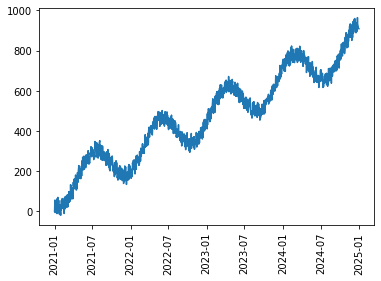

In [14]:
traffic_generator = WebTrafficGenerator(start_date='2021-01-01', 
                                        end_date='2024-12-31',
                                        trend_base=0.5, 
                                        weekly_seasonality=0.7,
                                        yearly_seasonality=2.3,
                                        noise_multiplier=80)
traffic = traffic_generator.generate_data()

plt.plot(traffic_generator.dates, traffic)
plt.xticks(rotation=90);

In [15]:
entities = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P"]
groups = {"High": ["A", "B", "C", "D", "E"], "Medium": ["F", "G", "H", "I", "J", "K"], "Low": ["L", "M", "N", "O", "P"]}

In [16]:
raw = pd.DataFrame(columns=['date', 'traffic', 'Entity', 'Class', 'DayOfWeek', 'DayOfMonth', 'WeekOfYear', 'Month', 'Year'])

for e in entities:
    trend_base = np.round(np.random.random(), 2)

    if e in groups["High"]:
        trend_base *= 1.5
        group = "High"
    elif e in groups["Low"]:
        trend_base *= 0.7
        group = "Low"
    else:
        group = "Medium"

    traffic_generator = WebTrafficGenerator(start_date='2020-01-01', 
                                            end_date='2024-12-31',
                                            trend_base=trend_base, 
                                            weekly_seasonality=0.7 +np.round(np.random.uniform(0, 2.0), 2),
                                            yearly_seasonality=6.0 +np.round(np.random.uniform(0, 2.0), 2),
                                            noise_multiplier=80)

    traffic = traffic_generator.generate_data()
    tmp = pd.DataFrame(data={"date": traffic_generator.dates, "traffic":traffic})
    tmp["Entity"] = [e]*tmp.shape[0]
    tmp["Class"] = [group]*tmp.shape[0]
    tmp["DayOfWeek"] = tmp.date.dt.dayofweek
    tmp["DayOfMonth"] = tmp.date.dt.day
    tmp["WeekOfYear"] = tmp.date.dt.isocalendar().week
    tmp["Month"] = tmp.date.dt.month
    tmp["Year"] = tmp.date.dt.year
    tmp["DaysFromStart"] = np.arange(tmp.shape[0])
    tmp["Delta"] = tmp["traffic"].diff().fillna(0)

    raw = pd.concat([raw, tmp])

raw.reset_index(inplace=True)

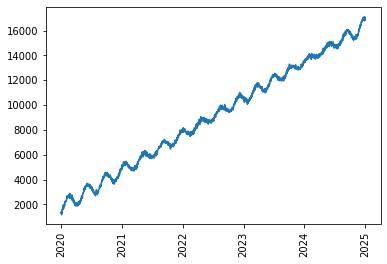

In [17]:
total = raw.groupby("date")["traffic"].sum()
plt.plot(total.index, total)
plt.xticks(rotation=90);

In [18]:
train = raw[raw['date'] < '2023-01-01']
valid = raw.loc[(raw['date'] >= '2023-01-01') & (raw['date'] < '2024-01-01')]
test = raw.loc[(raw['date'] > '2024-01-01')]

In [19]:
real_columns = ['traffic', "Delta", 'DaysFromStart']
categorical_columns = ['Entity', 'DayOfWeek', 'DayOfMonth', 'WeekOfYear', 'Month', 'Class']

real_scalers, categorical_scalers = fit_preprocessing(train, real_columns, categorical_columns)

train = transform_inputs(train, real_scalers, categorical_scalers, real_columns, categorical_columns)
valid = transform_inputs(valid, real_scalers, categorical_scalers, real_columns, categorical_columns)
test = transform_inputs(test, real_scalers, categorical_scalers, real_columns, categorical_columns)

In [20]:
# Global variables

DEVICE = "cuda"
BATCH_SIZE = 32
NUM_EPOCHS = 10
DROPOUT = 0.3
LEARNING_RATE = 0.001
ENCODER_STEPS = 175
DECODER_STEPS = 175 + 5
HIDDEN_LAYER_SIZE = 80
EMBEDDING_DIMENSION = 8
NUM_LSTM_LAYERS = 1
NUM_ATTENTION_HEADS = 2
QUANTILES = [0.1, 0.5, 0.9]


# Dataset variables
input_columns = ["traffic", "Delta", 'DaysFromStart', 'DayOfWeek', 'DayOfMonth', 'WeekOfYear', 'Month', 'Entity', 'Class', 'Entity']
target_column = "traffic"
entity_column = "Entity"
time_column = "date"
col_to_idx = {col: idx for idx, col in enumerate(input_columns)}


In [21]:
train[input_columns]

traffic     Delta  DaysFromStart  ...  Entity  Class  Entity
0     -0.950573 -0.015755      -1.730471  ...       0      0       0
1     -1.157306 -1.677905      -1.727311  ...       0      0       0
2     -0.997505  1.269062      -1.724150  ...       0      0       0
3     -1.030417 -0.280374      -1.720989  ...       0      0       0
4     -1.157798 -1.039902      -1.717828  ...       0      0       0
...         ...       ...            ...  ...     ...    ...     ...
28496  1.070189  1.306583       1.717828  ...      15      1      15
28497  0.841672 -1.853052       1.720989  ...      15      1      15
28498  0.900336  0.455912       1.724150  ...      15      1      15
28499  0.887205 -0.121329       1.727311  ...      15      1      15
28500  0.745598 -1.154287       1.730471  ...      15      1      15

[17536 rows x 10 columns]

In [22]:
params = {
    "quantiles": QUANTILES,
    "batch_size": BATCH_SIZE,
    "dropout": DROPOUT,
    "device": DEVICE,
    "hidden_layer_size": HIDDEN_LAYER_SIZE,
    "num_lstm_layers": NUM_LSTM_LAYERS,
    "embedding_dim": EMBEDDING_DIMENSION,
    "encoder_steps": ENCODER_STEPS,
    "num_attention_heads": NUM_ATTENTION_HEADS,
    "col_to_idx": col_to_idx,
    "static_covariates": ['Class', 'Entity'],
    "time_dependent_categorical": ['DayOfWeek', 'DayOfMonth', 'WeekOfYear', 'Month'],
    "time_dependent_continuous": ['traffic', 'DaysFromStart', "Delta"],
    "category_counts": {"DayOfWeek": 7, "DayOfMonth": 31, "WeekOfYear": 53, "Month": 12, "Class": 3, "Entity": 16},
    "known_time_dependent": ['DayOfWeek', 'DayOfMonth', 'WeekOfYear', 'Month', 'DaysFromStart'],
    "observed_time_dependent": ["traffic", "Delta"]
}

In [23]:
training_data = TFT_Dataset(train, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)
validation_data = TFT_Dataset(valid, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)
testing_data = TFT_Dataset(test, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)
valid_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)

In [24]:
model = TemporalFusionTransformer(params)
model.to(DEVICE)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


TemporalFusionTransformer(
  (static_embeddings): ModuleDict(
    (Class): Embedding(3, 8)
    (Entity): Embedding(16, 8)
  )
  (static_variable_selection): VariableSelectionNetwork(
    (flattened_inputs): GatedResidualNetwork(
      (skip_layer): Linear(in_features=16, out_features=2, bias=True)
      (dense1): Linear(in_features=16, out_features=80, bias=True)
      (elu): ELU(alpha=1.0)
      (dense2): Linear(in_features=80, out_features=2, bias=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (gate): GLU(
        (a): Linear(in_features=2, out_features=2, bias=True)
        (sigmoid): Sigmoid()
        (b): Linear(in_features=2, out_features=2, bias=True)
      )
      (layer_norm): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (transformed_inputs): ModuleList(
      (0): GatedResidualNetwork(
        (skip_layer): Linear(in_features=8, out_features=80, bias=True)
        (dense1): Linear(in_features=8, out_features=80, bias=Tru

In [25]:
criterion = QuantileLoss(QUANTILES)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print_every_k = 100
losses = []

for epoch in range(NUM_EPOCHS):
    t0 = time.time()
    print(f"===== Epoch {epoch+1} =========")
    epoch_loss = 0.0
    running_loss = 0.0

    for i, batch in enumerate(train_dataloader):
        labels = batch['outputs'][:,:,0].flatten().float().to(DEVICE)

        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs, attention_weights = model(batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        epoch_loss += loss.item()

        if (i+1) % print_every_k == 0:
            print(f"Mini-batch {i+1} average loss: {round(running_loss / print_every_k, 5)}")
            running_loss = 0.0
    
    t1 = time.time()
    print(f"\nEpoch trained for {round(t1-t0, 2)} seconds")
    print("\nEpoch loss:", round(epoch_loss / (i+1), 5), "\n")
    losses.append(epoch_loss / (i+1))
    



===== Epoch 1 =========
Mini-batch 100 average loss: 1.32496
Mini-batch 200 average loss: 0.55924
Mini-batch 300 average loss: 0.50789
Mini-batch 400 average loss: 0.69447

Epoch trained for 66.42 seconds

Epoch loss: 0.7302 

===== Epoch 2 =========
Mini-batch 100 average loss: 1.20941
Mini-batch 200 average loss: 0.5957
Mini-batch 300 average loss: 0.56828
Mini-batch 400 average loss: 0.71548

Epoch trained for 64.97 seconds

Epoch loss: 0.72898 

===== Epoch 3 =========
Mini-batch 100 average loss: 1.05879
Mini-batch 200 average loss: 0.47903
Mini-batch 300 average loss: 0.50704
Mini-batch 400 average loss: 0.67429

Epoch trained for 64.74 seconds

Epoch loss: 0.6457 

===== Epoch 4 =========
Mini-batch 100 average loss: 1.057
Mini-batch 200 average loss: 0.5028
Mini-batch 300 average loss: 0.54149
Mini-batch 400 average loss: 0.62318

Epoch trained for 64.9 seconds

Epoch loss: 0.64713 

===== Epoch 5 =========
Mini-batch 100 average loss: 0.82963
Mini-batch 200 average loss: 0.474

In [27]:
out_df = pd.DataFrame(columns=['p10', 'p50', 'p90', 'identifier'])

for i, batch in enumerate(test_dataloader):

    outputs, attention_weights = model(batch)
    bs = batch["outputs"].shape[0]

    process_map = {f"p{int(q * 100)}": outputs.reshape(bs, 5, 3)[:, :, i].cpu().detach().numpy()[::5,:].reshape(-1)[:bs] for i, q in enumerate(QUANTILES)}

    tmp = pd.DataFrame(data=process_map, index=pd.to_datetime(batch['time'][:, ENCODER_STEPS - 1, 0]))
    tmp["labels"] = batch["outputs"].reshape(-1)[::5]
    tmp["identifier"] = batch['identifier'][:, 0, 0]

    out_df = pd.concat([out_df, tmp])


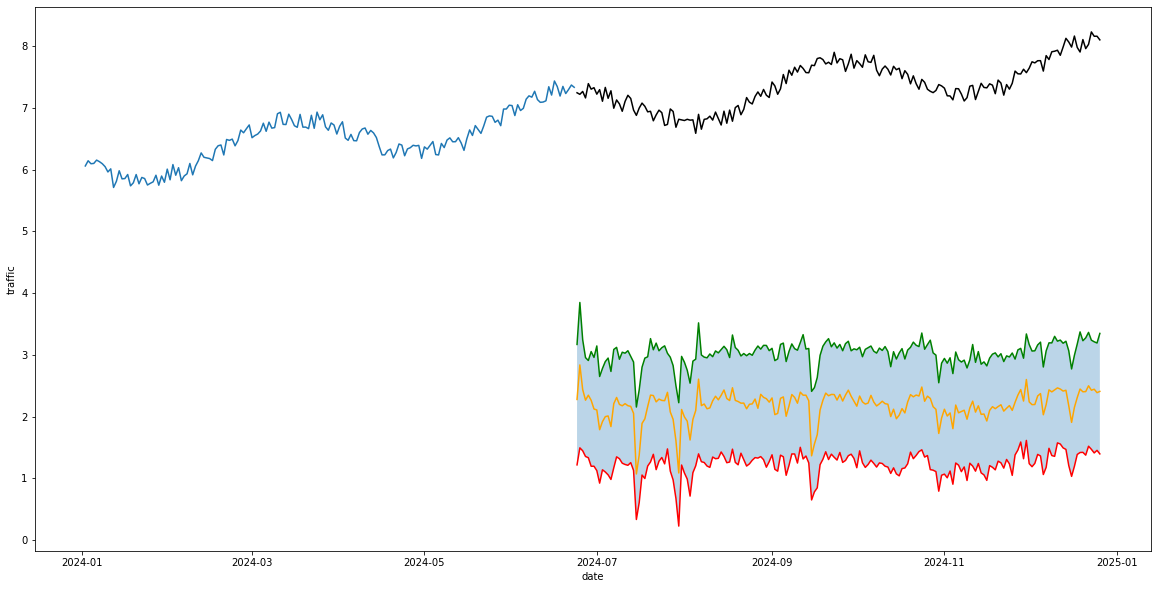

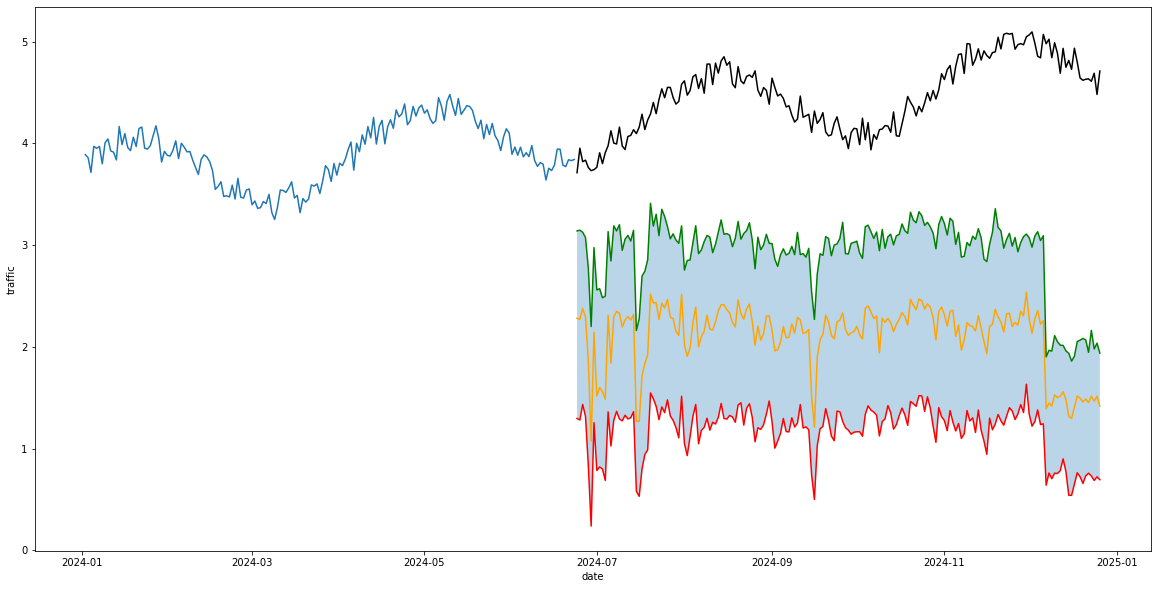

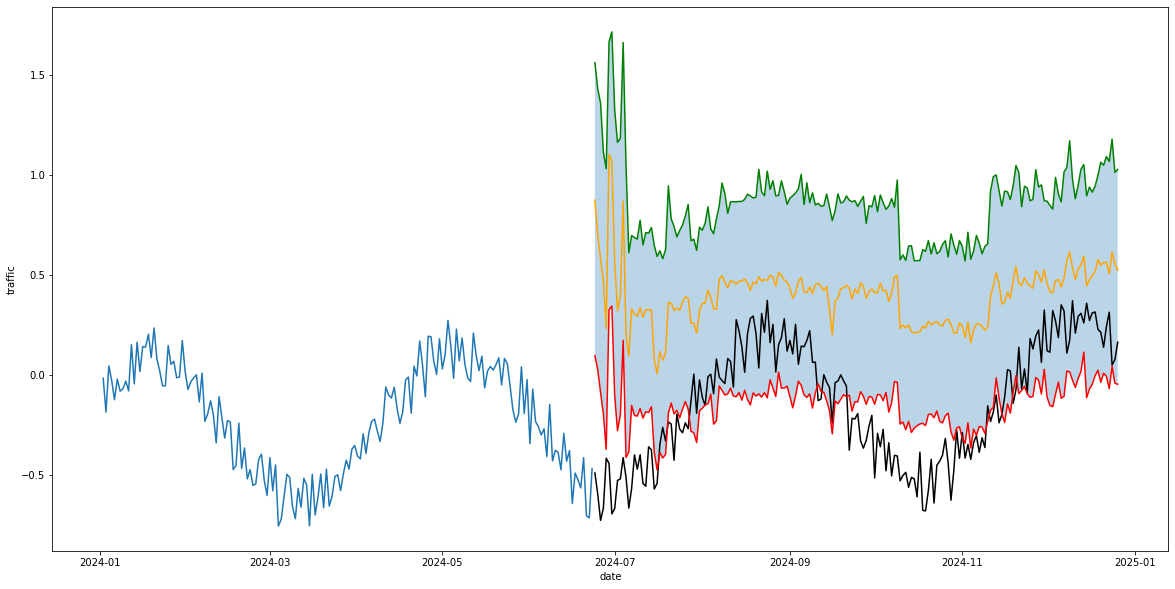

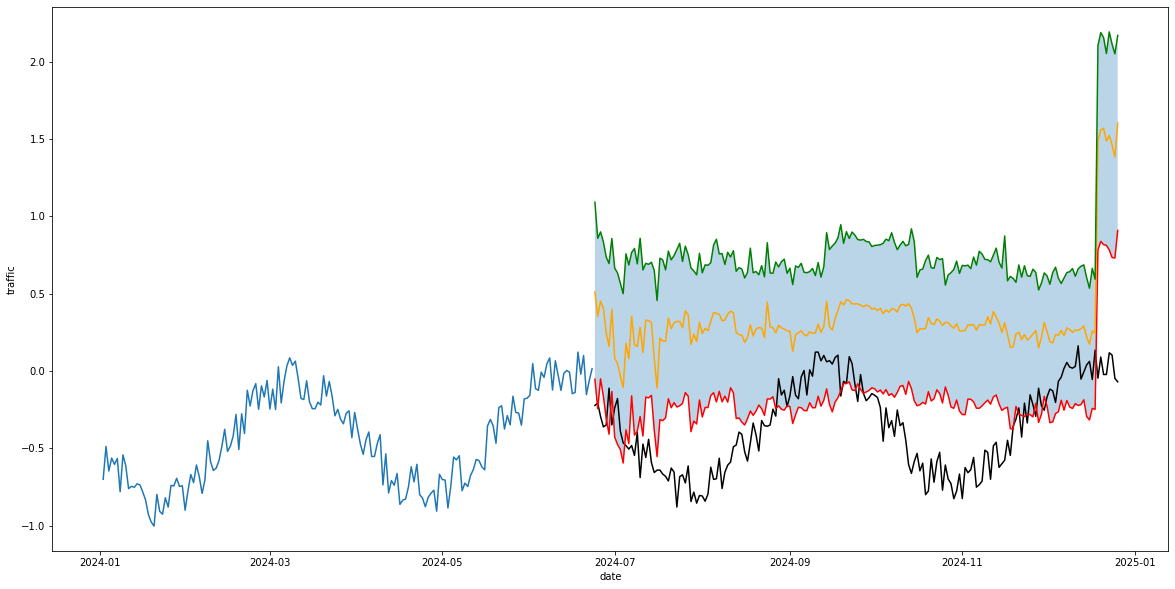

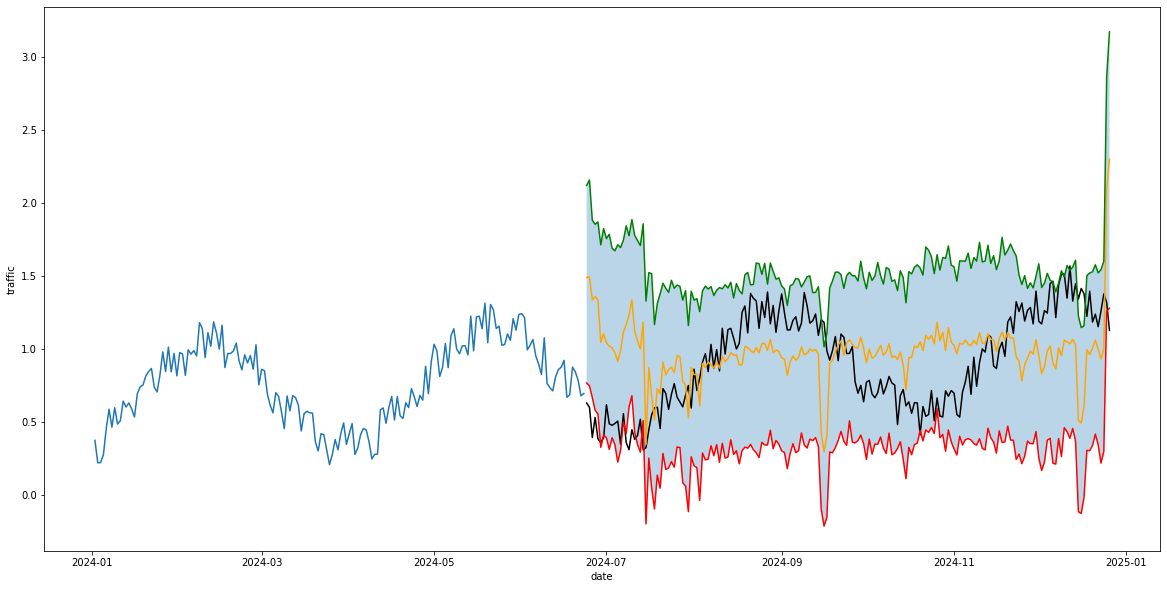

In [28]:
for i in range(5):
    plt.figure(figsize=(20,10))
    sns.lineplot(x=test[test["Entity"]==i].iloc[:ENCODER_STEPS-1]["date"], y=test[test["Entity"]==i].iloc[:ENCODER_STEPS-1]["traffic"])
    sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].labels, color="black")
    sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p10, color="red")
    sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p50, color="orange")
    sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p90, color="green")

    plt.fill_between(out_df[out_df["identifier"]==i].index, out_df[out_df["identifier"]==i].p10, out_df[out_df["identifier"]==i].p90, alpha=0.3)

    plt.show()

## Volatility data

In the next lines we can see the result of running our version of the Temporal Fusion Transformer Model on one of the datasets used by the authors in the original paper.

In [29]:
raw_data = pd.read_csv('./outputs/data/volatility/formatted_omi_vol.csv', index_col=0)
raw_data["date"] = pd.to_datetime(raw_data["date"])

train = raw_data[raw_data['year'] < 2016]
valid = raw_data.loc[(raw_data['year'] >= 2016) & (raw_data['year'] < 2018)]
test = raw_data.loc[(raw_data['year'] >= 2018) & (raw_data.index <= '2019-06-28')]

In [30]:
train.head()

Symbol  open_to_close  ...   log_vol  Region
2000-01-03 00:00:00+00:00   .AEX      -0.000340  ... -8.946668    EMEA
2000-01-04 00:00:00+00:00   .AEX      -0.033606  ... -8.510686    EMEA
2000-01-05 00:00:00+00:00   .AEX      -0.001675  ... -7.619135    EMEA
2000-01-06 00:00:00+00:00   .AEX      -0.013130  ... -8.398790    EMEA
2000-01-07 00:00:00+00:00   .AEX       0.025013  ... -8.885257    EMEA

[5 rows x 29 columns]

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109882 entries, 2000-01-03 00:00:00+00:00 to 2015-12-31 00:00:00+00:00
Data columns (total 29 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Symbol           109882 non-null  object        
 1   open_to_close    109882 non-null  float64       
 2   rsv_ss           109882 non-null  float64       
 3   close_time       109882 non-null  float64       
 4   close_price      109882 non-null  float64       
 5   rsv              109882 non-null  float64       
 6   rk_twoscale      109882 non-null  float64       
 7   open_price       109882 non-null  float64       
 8   medrv            109881 non-null  float64       
 9   nobs             109882 non-null  float64       
 10  rk_th2           109882 non-null  float64       
 11  rv5              109882 non-null  float64       
 12  bv_ss            109882 non-null  float64       
 13  rv10_ss          109882 non-null  fl

In [32]:
real_columns = ['log_vol', 'open_to_close', 'days_from_start']
categorical_columns = ['Symbol', 'day_of_week', 'day_of_month', 'week_of_year', 'month', 'Region']

real_scalers, categorical_scalers = fit_preprocessing(train, real_columns, categorical_columns)

train = transform_inputs(train, real_scalers, categorical_scalers, real_columns, categorical_columns)
valid = transform_inputs(valid, real_scalers, categorical_scalers, real_columns, categorical_columns)
test = transform_inputs(test, real_scalers, categorical_scalers, real_columns, categorical_columns)

In [41]:
# Global variables

DEVICE = "cuda"
BATCH_SIZE = 64
NUM_EPOCHS = 10
DROPOUT = 0.3
LEARNING_RATE = 0.001
ENCODER_STEPS = 252
DECODER_STEPS = 252 + 5
HIDDEN_LAYER_SIZE = 160
EMBEDDING_DIMENSION = 8
NUM_LSTM_LAYERS = 1
NUM_ATTENTION_HEADS = 1
QUANTILES = [0.1, 0.5, 0.9]


# Dataset variables
input_columns = ["log_vol", "open_to_close", "days_from_start", "day_of_week", "day_of_month", "week_of_year", "month", "Region", "Symbol"]
target_column = "log_vol"
entity_column = "Symbol"
time_column = "date"
col_to_idx = {col: idx for idx, col in enumerate(input_columns)}


In [42]:
params = {
    "quantiles": QUANTILES,
    "batch_size": BATCH_SIZE,
    "dropout": DROPOUT,
    "device": DEVICE,
    "hidden_layer_size": HIDDEN_LAYER_SIZE,
    "num_lstm_layers": NUM_LSTM_LAYERS,
    "embedding_dim": EMBEDDING_DIMENSION,
    "encoder_steps": ENCODER_STEPS,
    "num_attention_heads": NUM_ATTENTION_HEADS,
    "col_to_idx": col_to_idx,
    "static_covariates": ["Region", "Symbol"],
    "time_dependent_categorical": ["day_of_week", "day_of_month", "week_of_year", "month"],
    "time_dependent_continuous": ['log_vol', 'days_from_start', "open_to_close",],
    "category_counts": {"day_of_week": 7, "day_of_month": 31, "week_of_year": 53, "month": 12, "Region": 4, "Symbol": 31},
    "known_time_dependent": ["day_of_week", "day_of_month", "week_of_year", "month", "days_from_start"],
    "observed_time_dependent": ["log_vol", "open_to_close"]
}

In [43]:
training_data = TFT_Dataset(train, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)
validation_data = TFT_Dataset(valid, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)
testing_data = TFT_Dataset(test, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)
valid_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [44]:
model = TemporalFusionTransformer(params)
model.to(DEVICE)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


TemporalFusionTransformer(
  (static_embeddings): ModuleDict(
    (Region): Embedding(4, 8)
    (Symbol): Embedding(31, 8)
  )
  (static_variable_selection): VariableSelectionNetwork(
    (flattened_inputs): GatedResidualNetwork(
      (skip_layer): Linear(in_features=16, out_features=2, bias=True)
      (dense1): Linear(in_features=16, out_features=160, bias=True)
      (elu): ELU(alpha=1.0)
      (dense2): Linear(in_features=160, out_features=2, bias=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (gate): GLU(
        (a): Linear(in_features=2, out_features=2, bias=True)
        (sigmoid): Sigmoid()
        (b): Linear(in_features=2, out_features=2, bias=True)
      )
      (layer_norm): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (transformed_inputs): ModuleList(
      (0): GatedResidualNetwork(
        (skip_layer): Linear(in_features=8, out_features=160, bias=True)
        (dense1): Linear(in_features=8, out_features=160, bia

In [45]:
criterion = QuantileLoss(QUANTILES)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print_every_k = 100
losses = []
for epoch in range(NUM_EPOCHS):
    t0 = time.time()
    print(f"===== Epoch {epoch+1} =========")
    epoch_loss = 0.0
    running_loss = 0.0

    for i, batch in enumerate(train_dataloader):
        labels = batch['outputs'][:,:,0].flatten().float().to(DEVICE)

        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs, attention_weights = model(batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        epoch_loss += loss.item()

        if (i+1) % print_every_k == 0:
            print(f"Mini-batch {i+1} average loss: {round(running_loss / print_every_k, 5)}")
            running_loss = 0.0
    
    t1 = time.time()
    print(f"\nEpoch trained for {round(t1-t0, 2)} seconds")
    print("\nEpoch loss:", round(epoch_loss / (i+1), 5), "\n")
    losses.append(epoch_loss / (i+1))
    



===== Epoch 1 =========
Mini-batch 100 average loss: 0.84518
Mini-batch 200 average loss: 0.72147
Mini-batch 300 average loss: 0.67561
Mini-batch 400 average loss: 0.80343
Mini-batch 500 average loss: 0.6983
Mini-batch 600 average loss: 0.84689
Mini-batch 700 average loss: 0.71579
Mini-batch 800 average loss: 0.7541
Mini-batch 900 average loss: 0.73635
Mini-batch 1000 average loss: 0.70909
Mini-batch 1100 average loss: 0.74821
Mini-batch 1200 average loss: 0.72011
Mini-batch 1300 average loss: 0.7711
Mini-batch 1400 average loss: 0.79099
Mini-batch 1500 average loss: 0.7986

Epoch trained for 490.68 seconds

Epoch loss: 0.7513 

===== Epoch 2 =========
Mini-batch 100 average loss: 0.84077
Mini-batch 200 average loss: 0.71303
Mini-batch 300 average loss: 0.664
Mini-batch 400 average loss: 0.76928
Mini-batch 500 average loss: 0.67182
Mini-batch 600 average loss: 0.77679
Mini-batch 700 average loss: 0.65483
Mini-batch 800 average loss: 0.63422
Mini-batch 900 average loss: 0.65172
Mini-bat

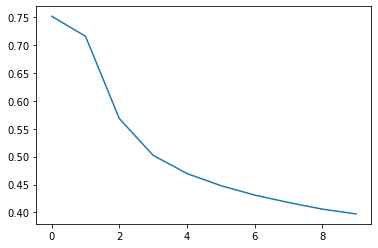

In [46]:
plt.plot(losses)

In [47]:
from google.colab import files
torch.save(model.state_dict(), 'checkpoint.pth')

# download checkpoint file
files.download('checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
out_df = pd.DataFrame(columns=['p10', 'p50', 'p90', 'identifier'])

for i, batch in enumerate(test_dataloader):

    outputs, attention_weights = model(batch)
    bs = batch["outputs"].shape[0]

    process_map = {f"p{int(q * 100)}": outputs.reshape(bs, 5, 3)[:, :, i].cpu().detach().numpy()[::5,:].reshape(-1)[:bs] for i, q in enumerate(QUANTILES)}

    tmp = pd.DataFrame(data=process_map, index=pd.to_datetime(batch['time'][:, ENCODER_STEPS - 1, 0]))
    tmp["labels"] = batch["outputs"].reshape(-1)[::5]
    tmp["identifier"] = batch['identifier'][:, 0, 0]

    out_df = pd.concat([out_df, tmp])


In [55]:
test.Symbol.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

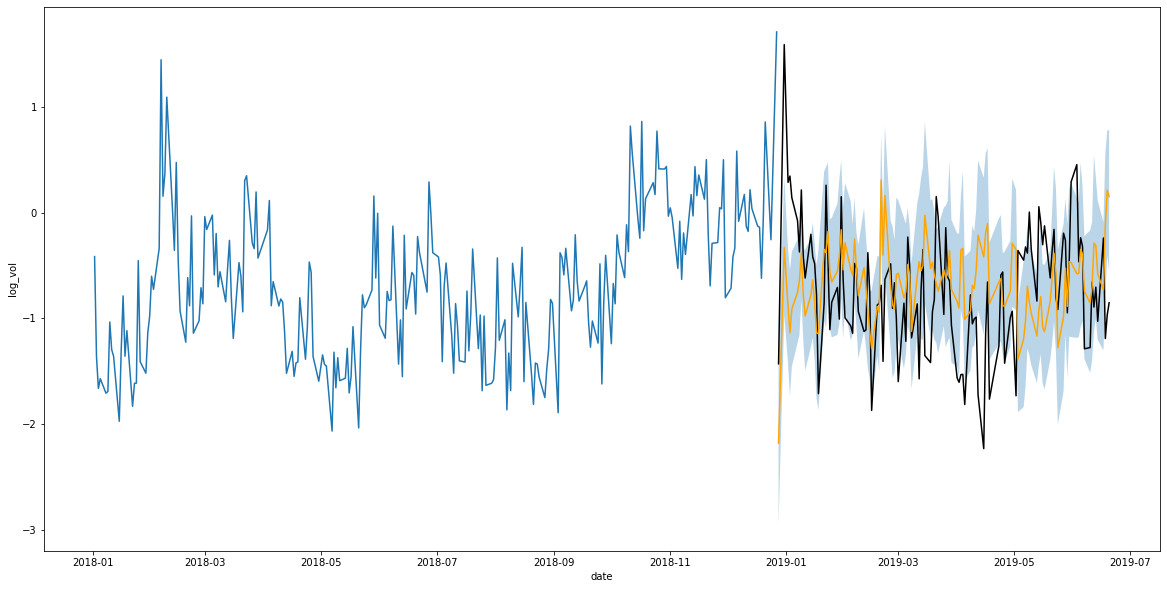

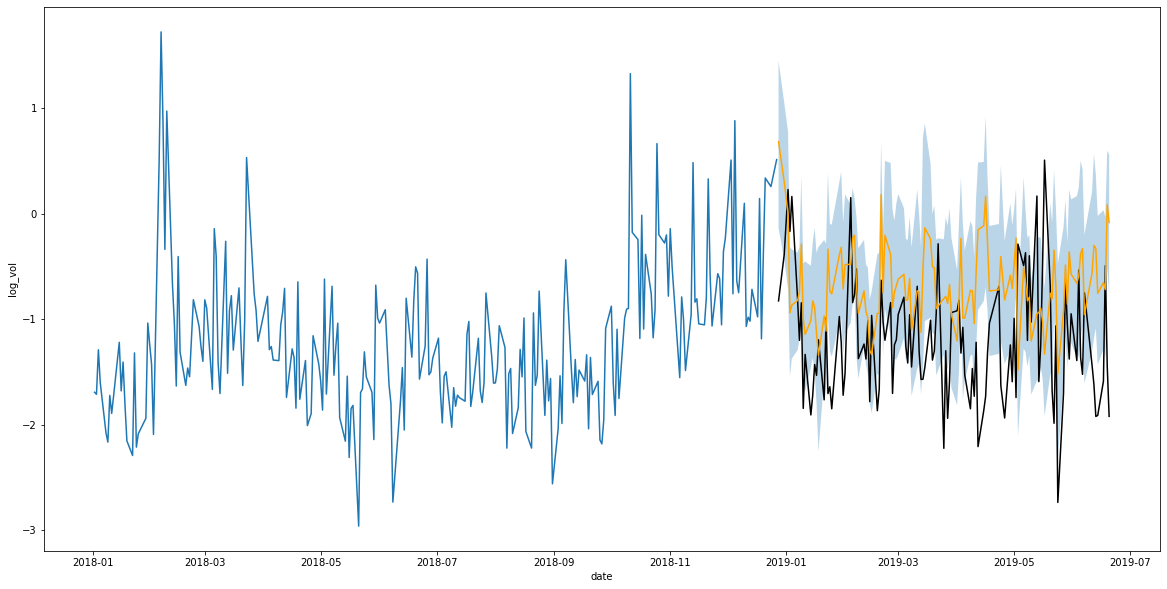

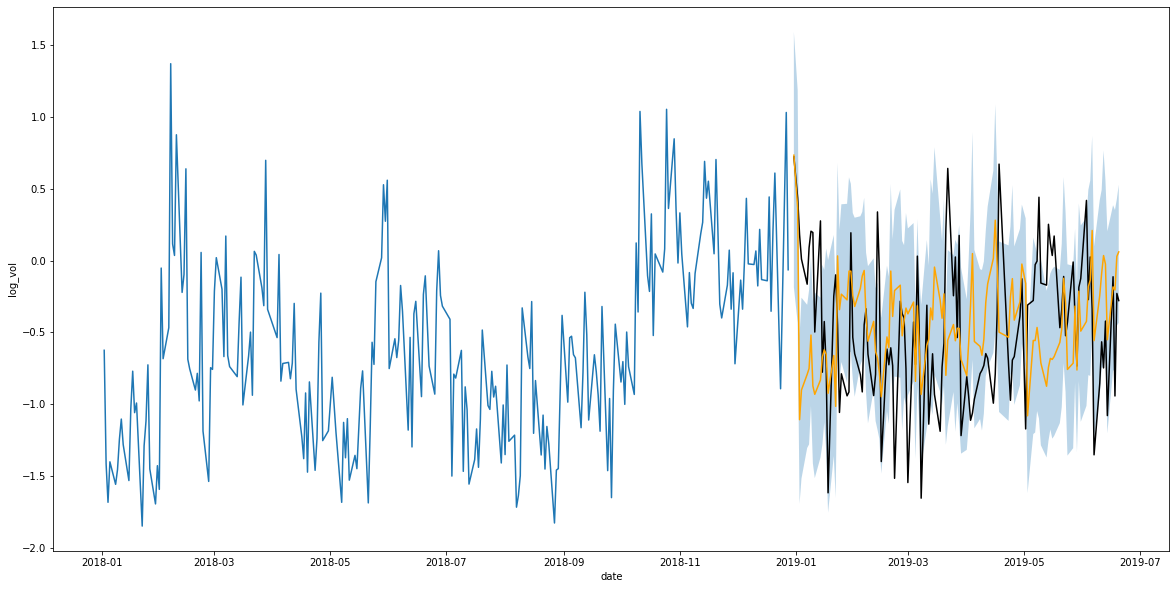

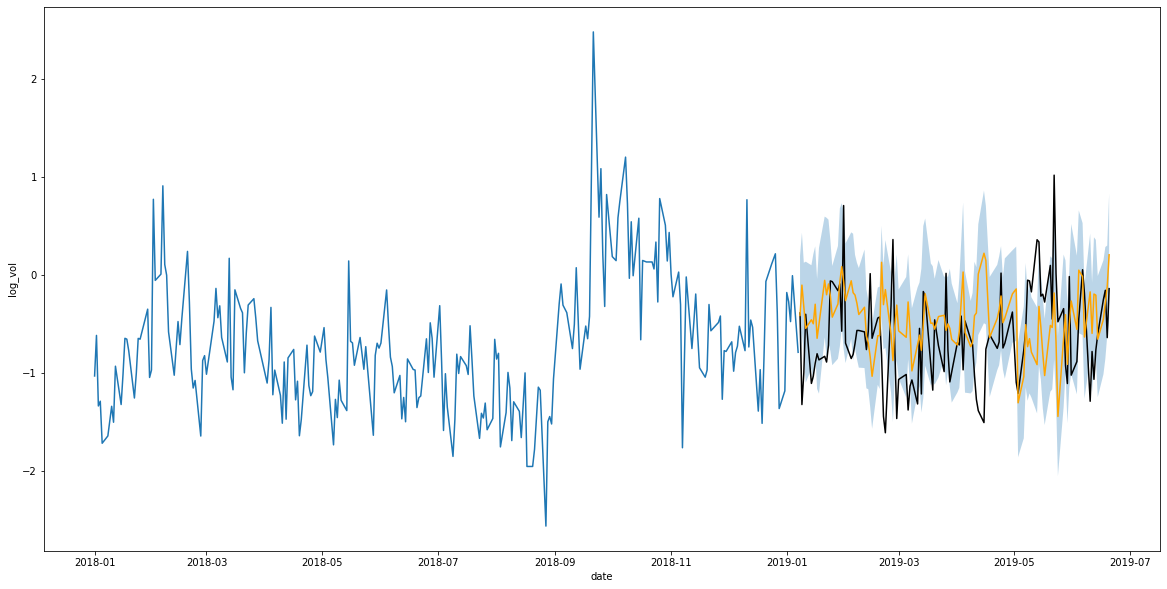

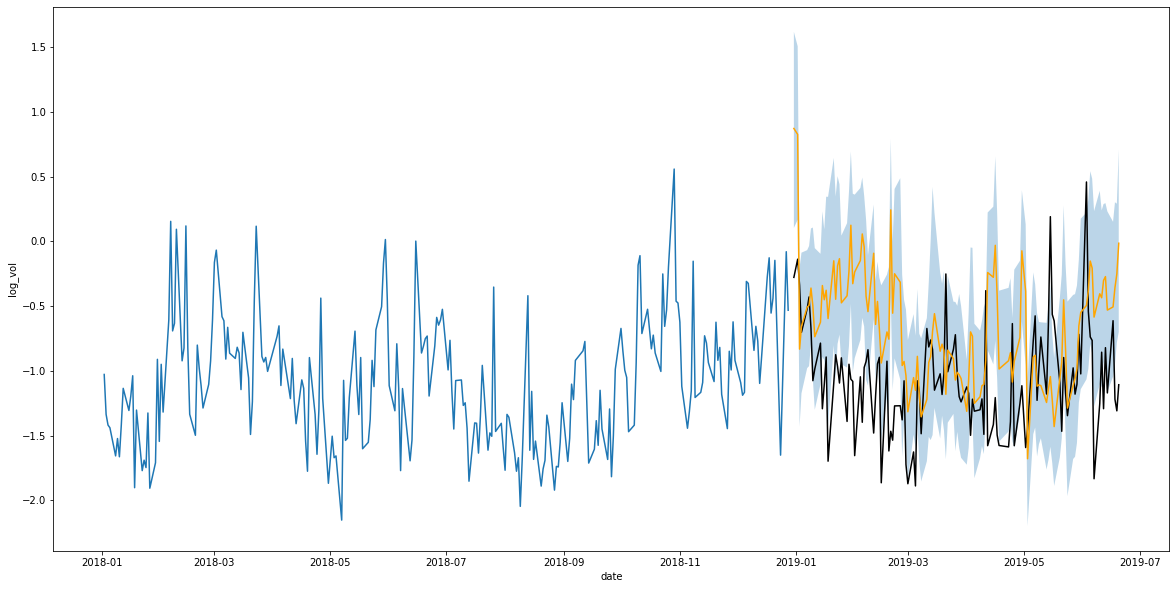

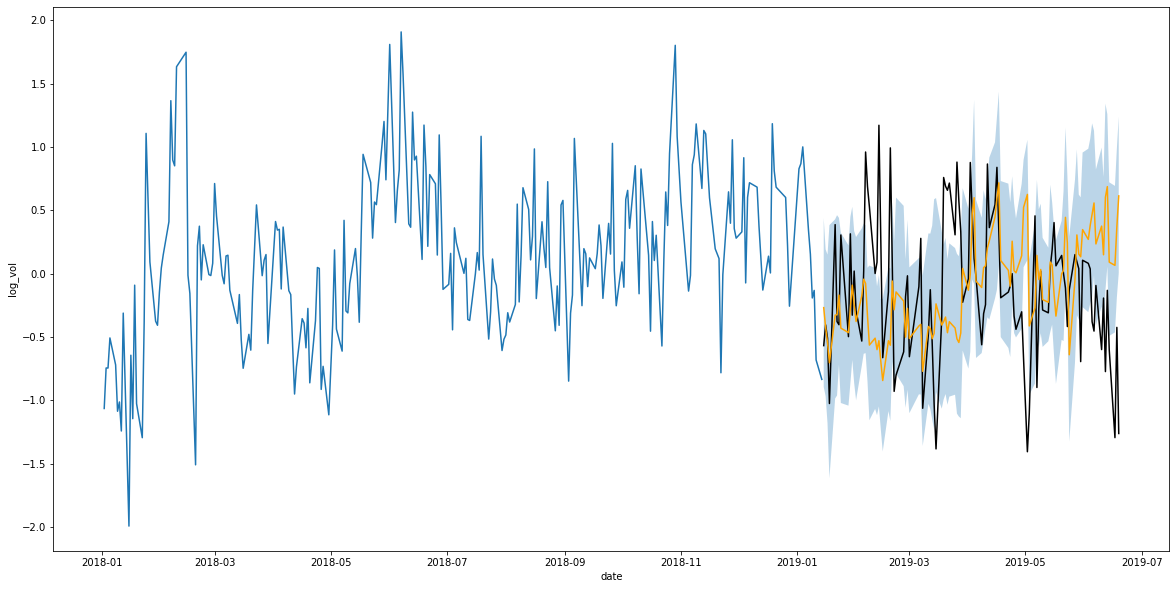

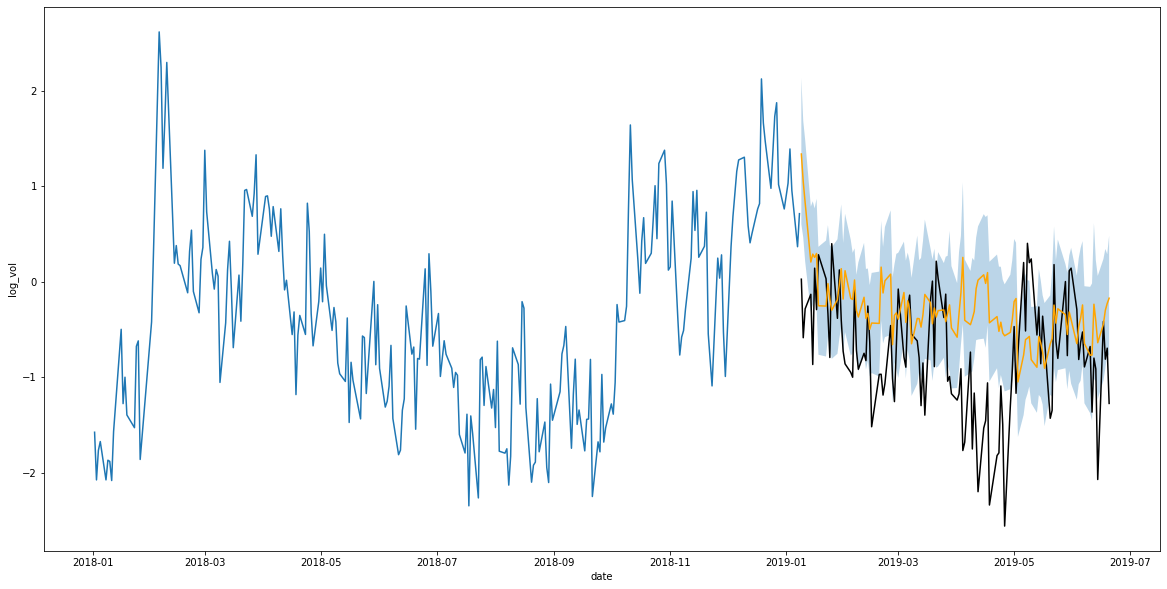

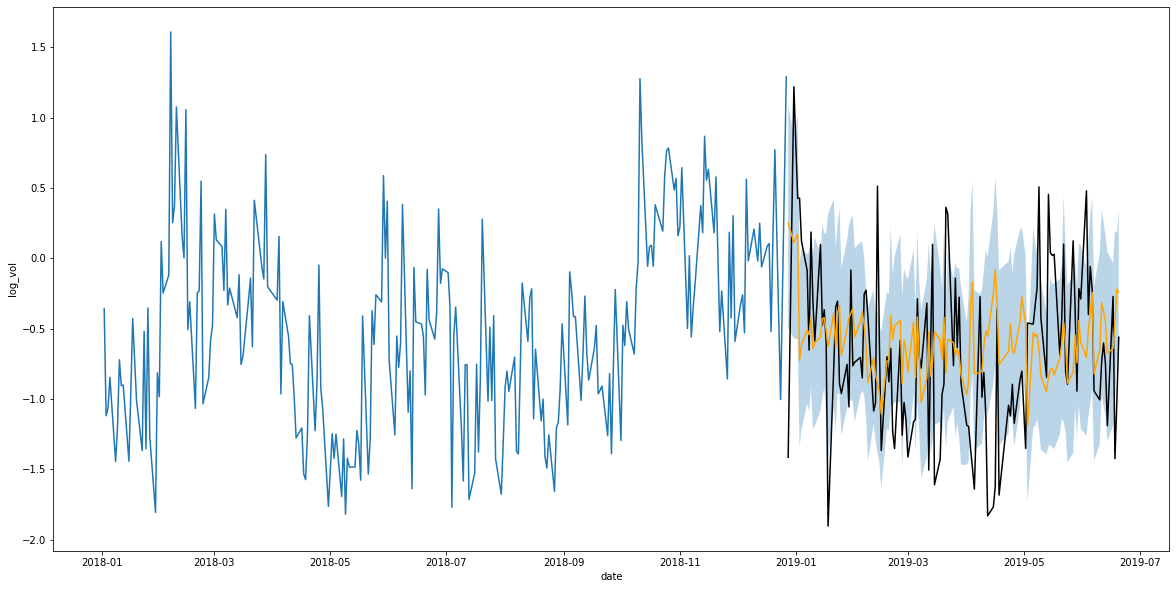

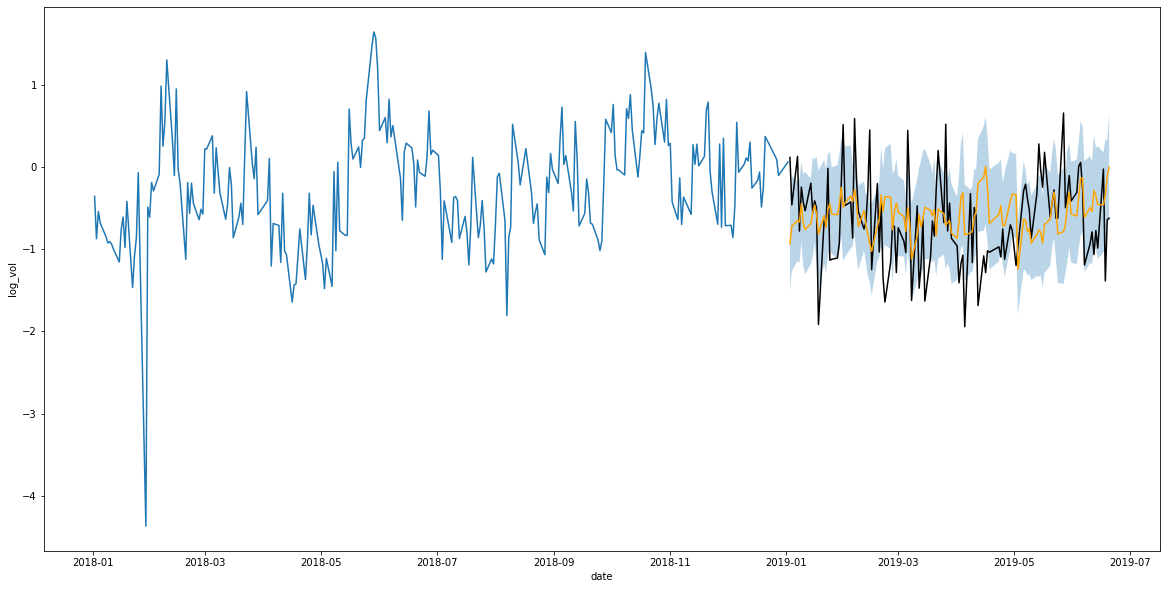

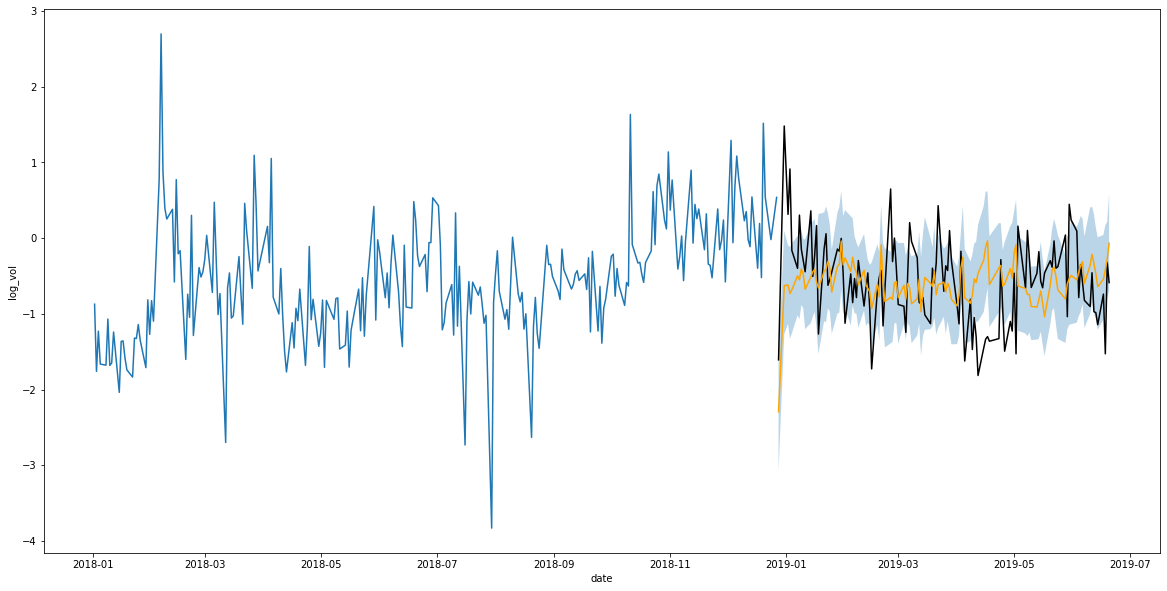

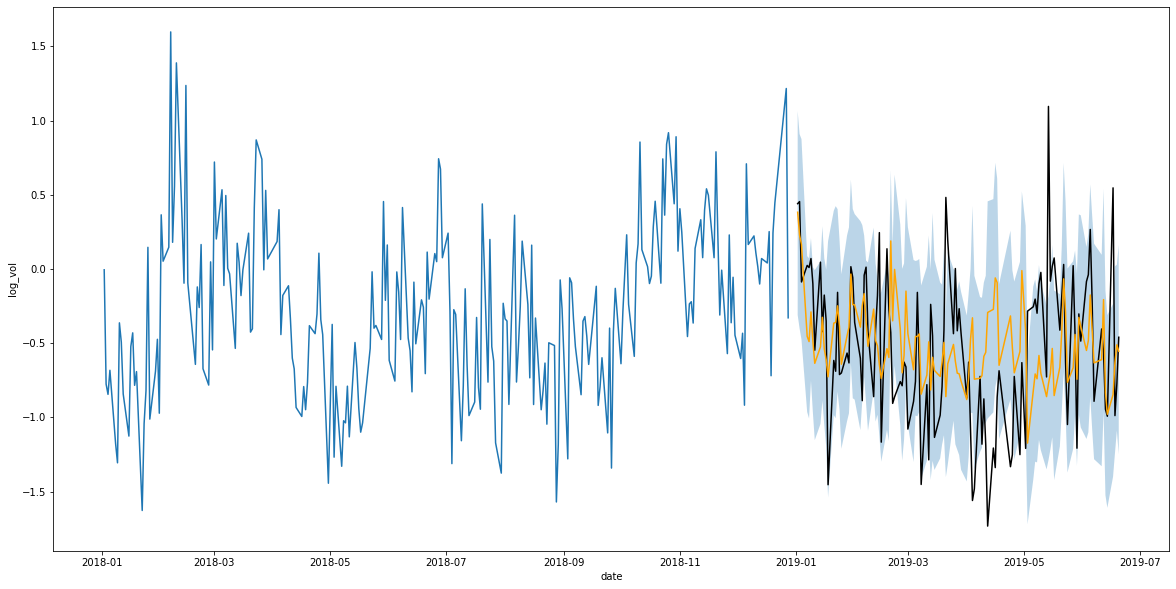

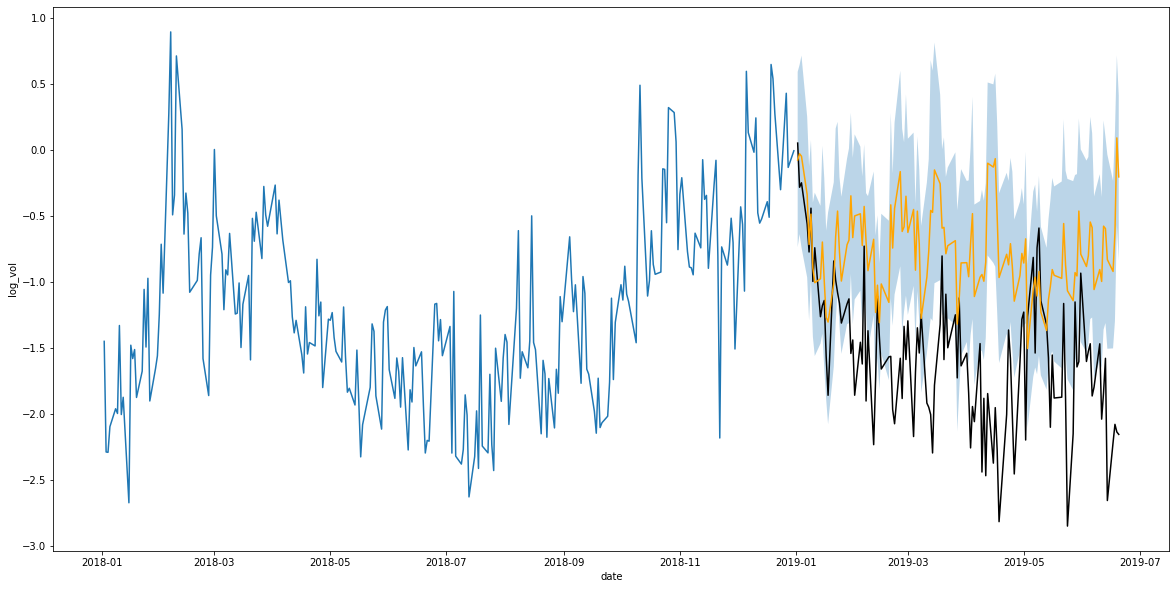

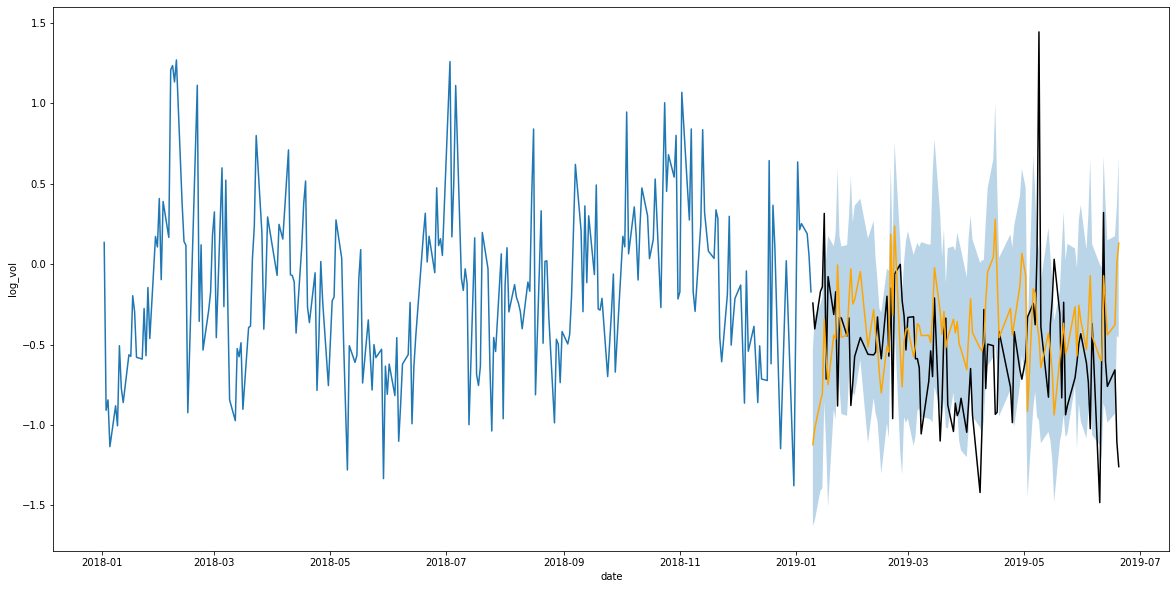

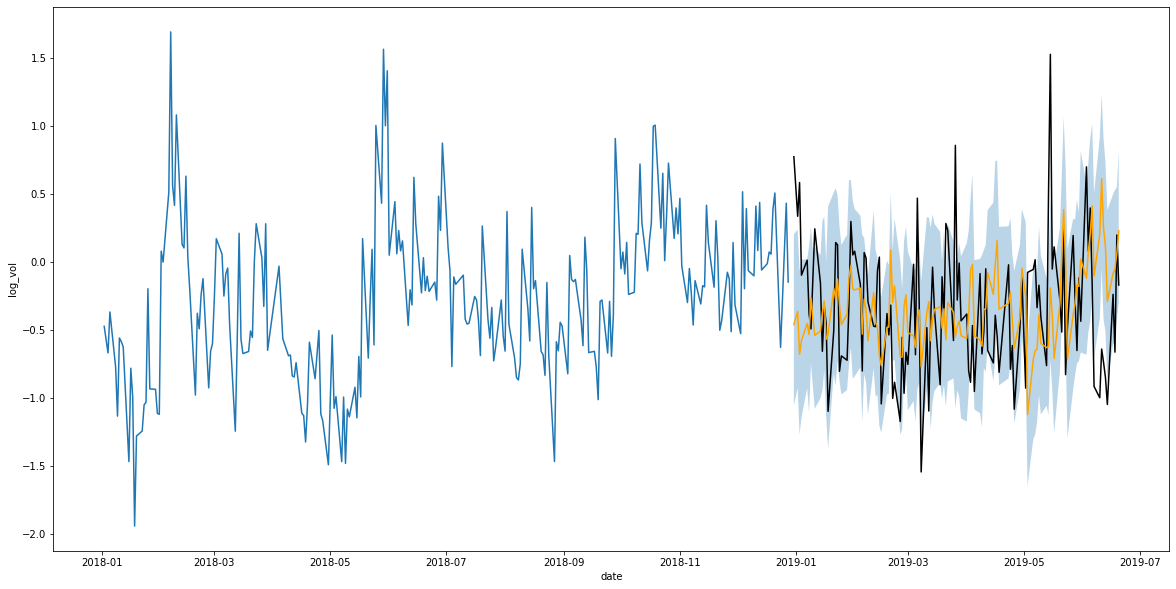

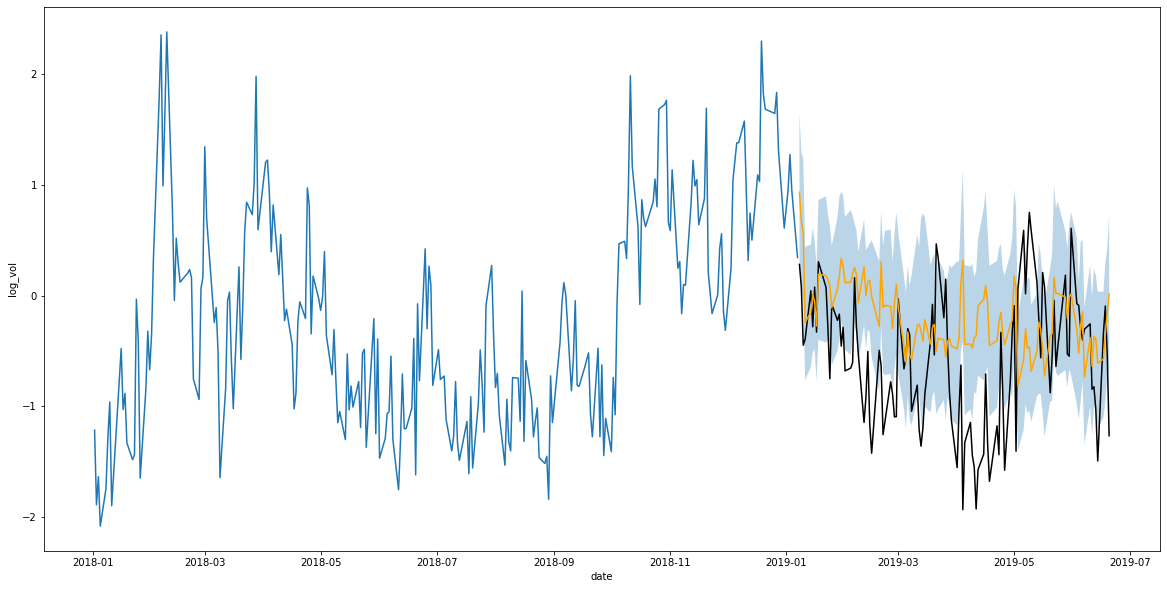

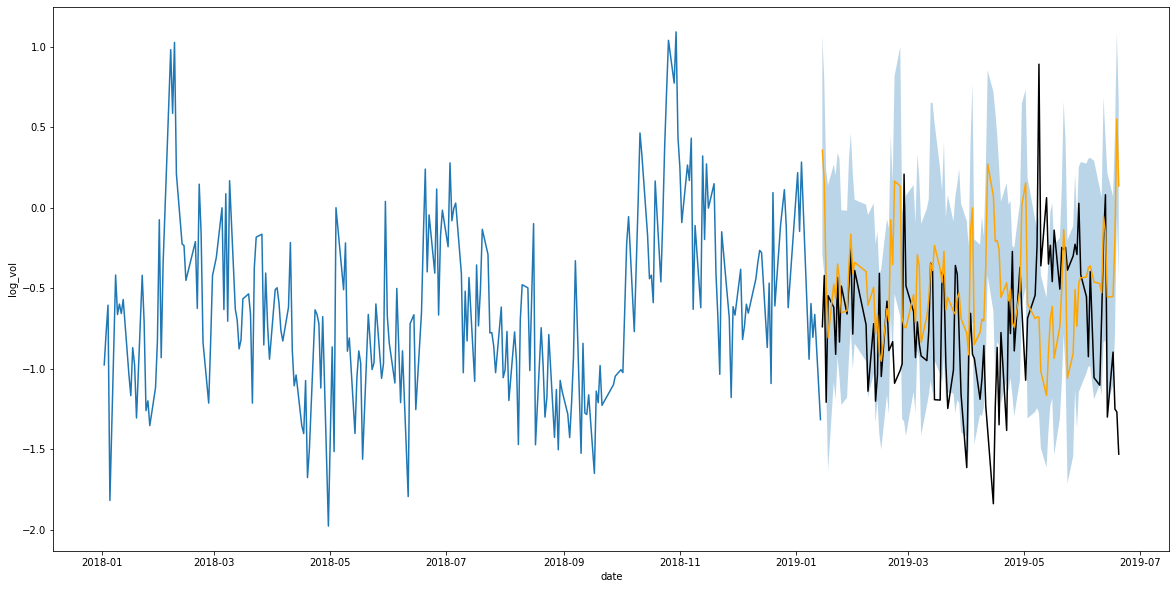

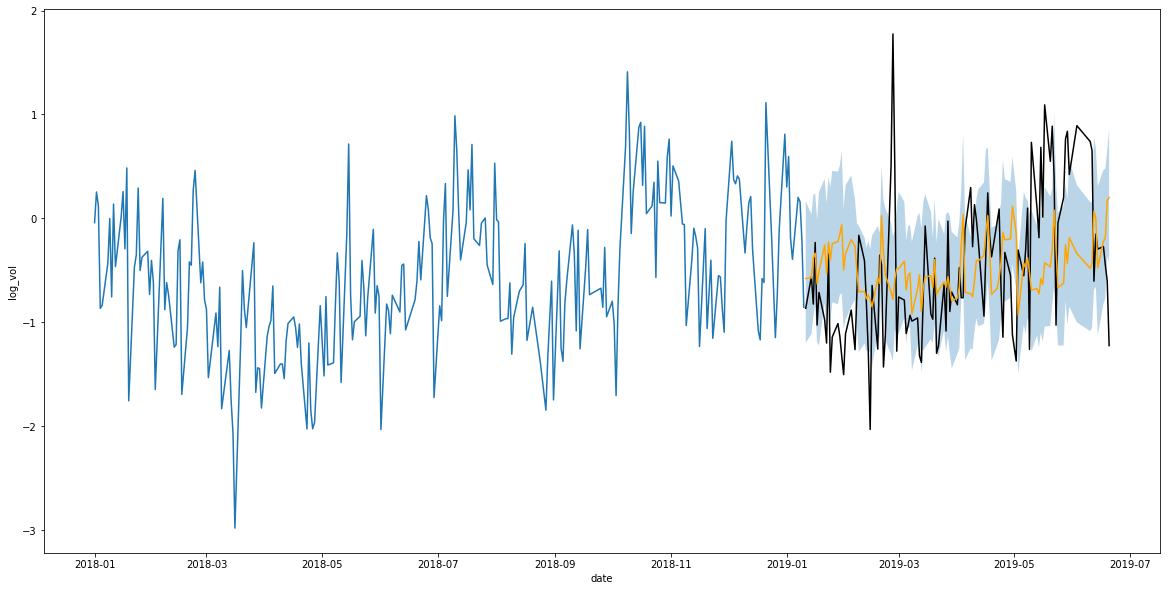

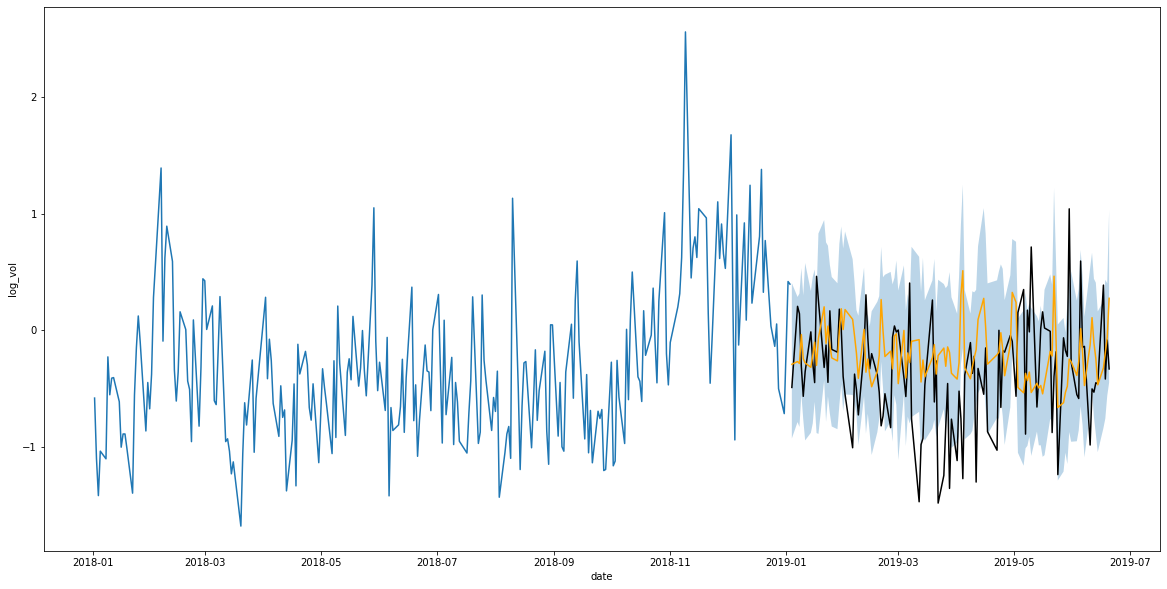

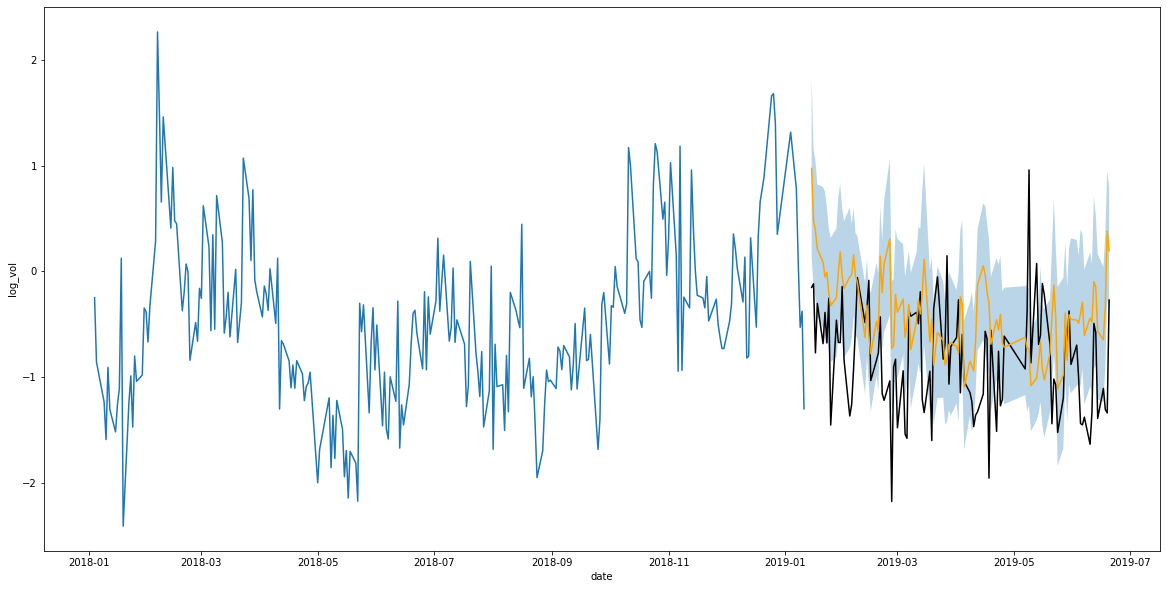

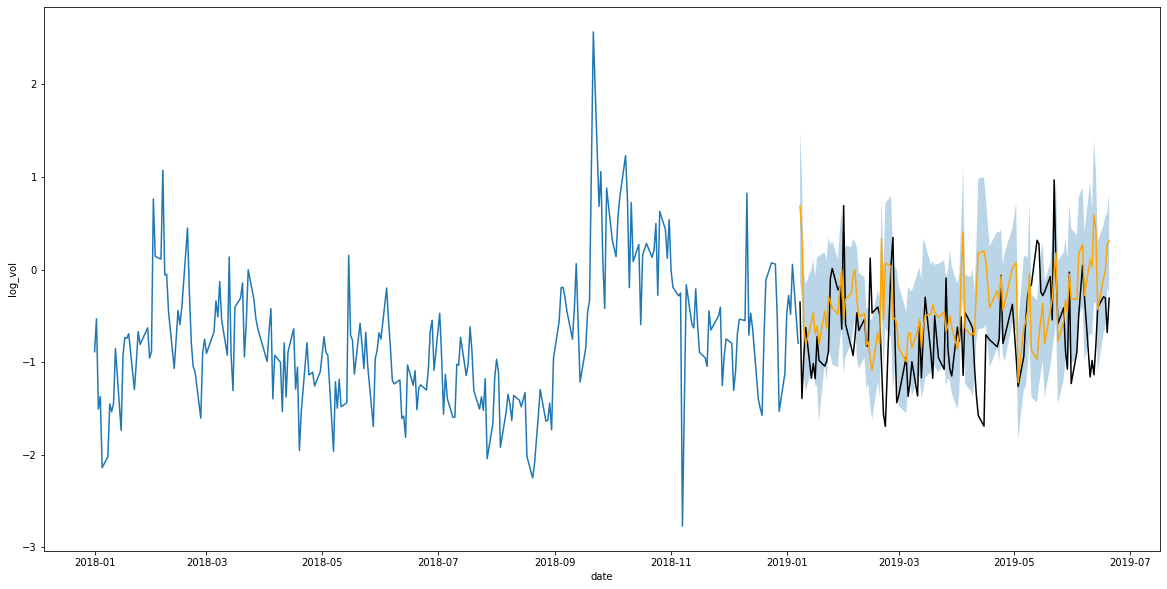

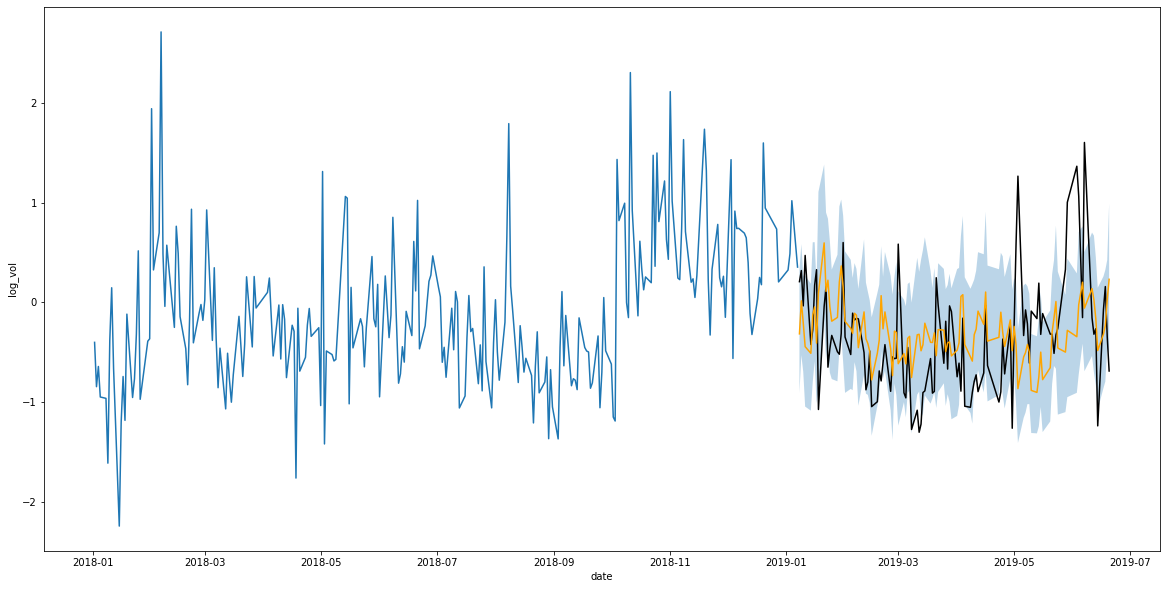

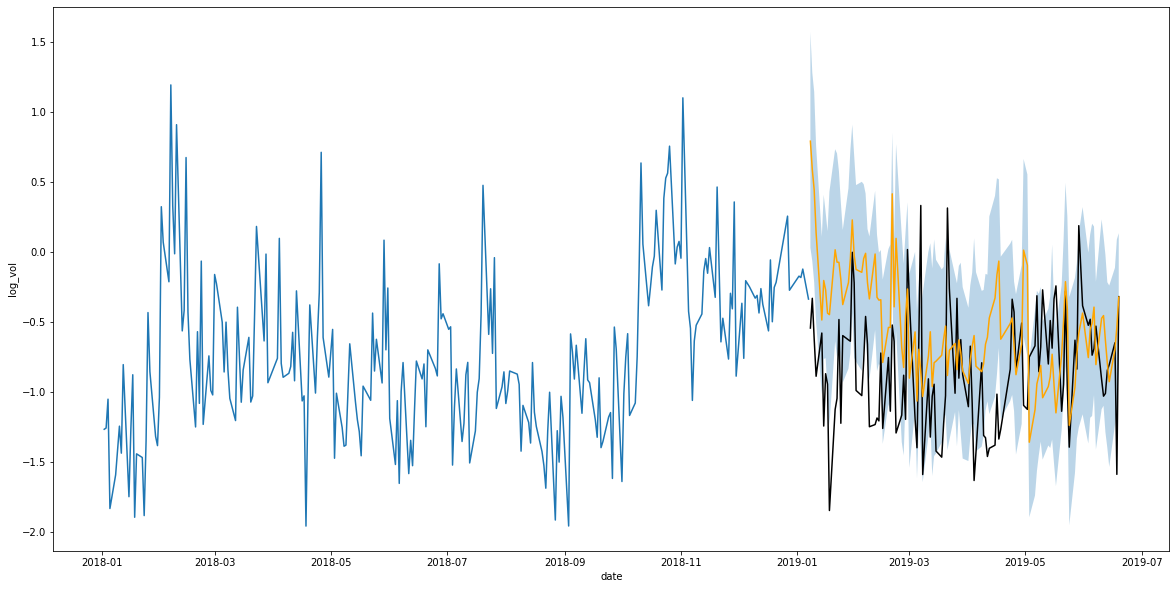

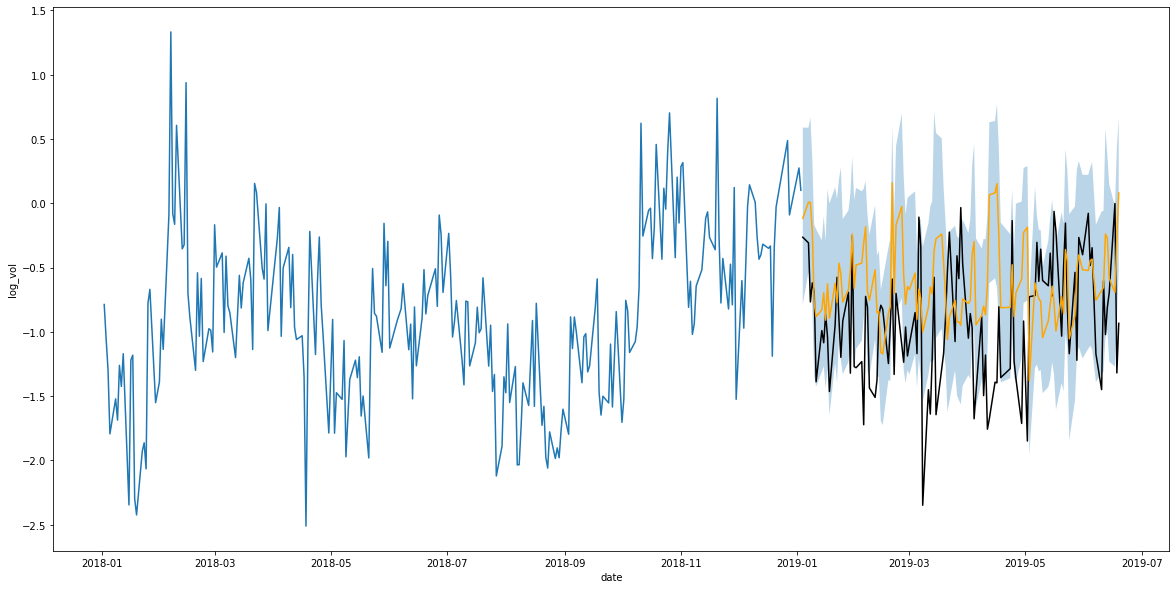

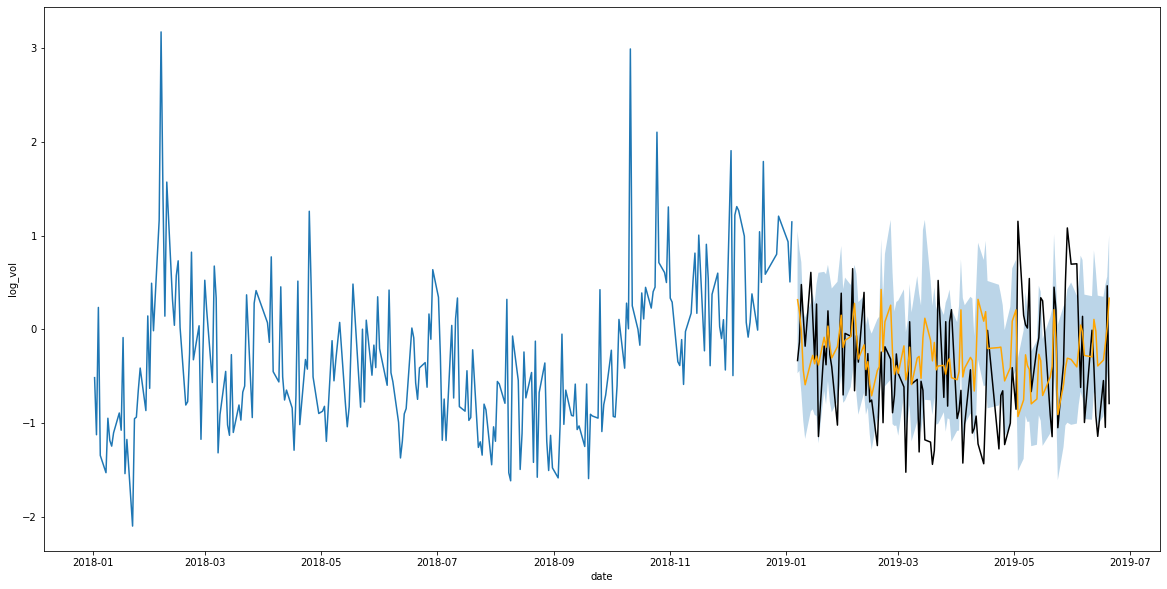

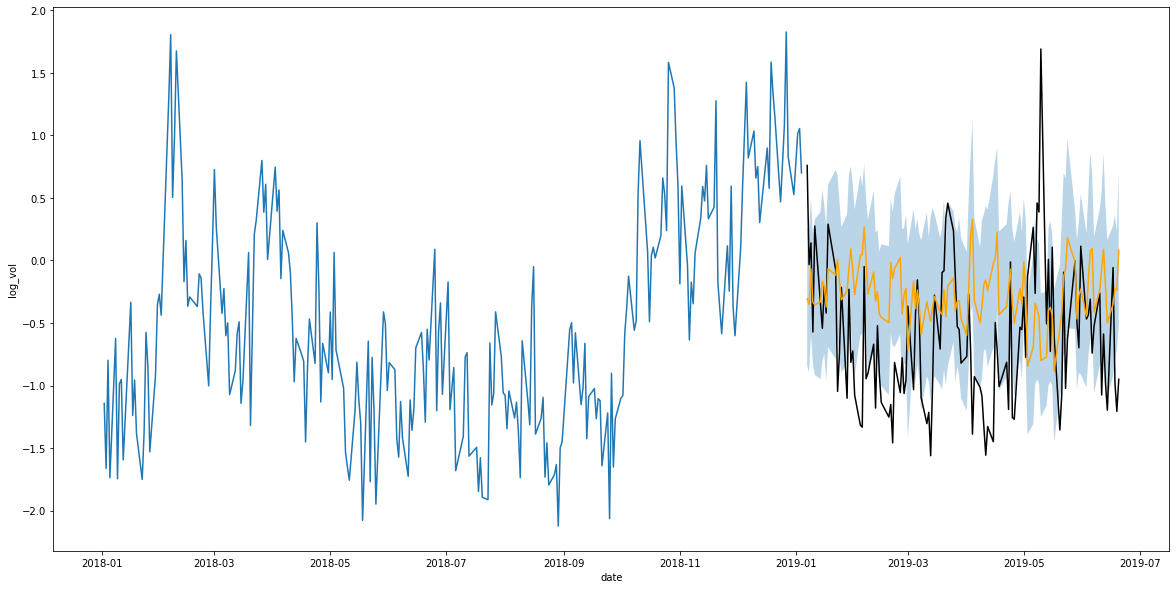

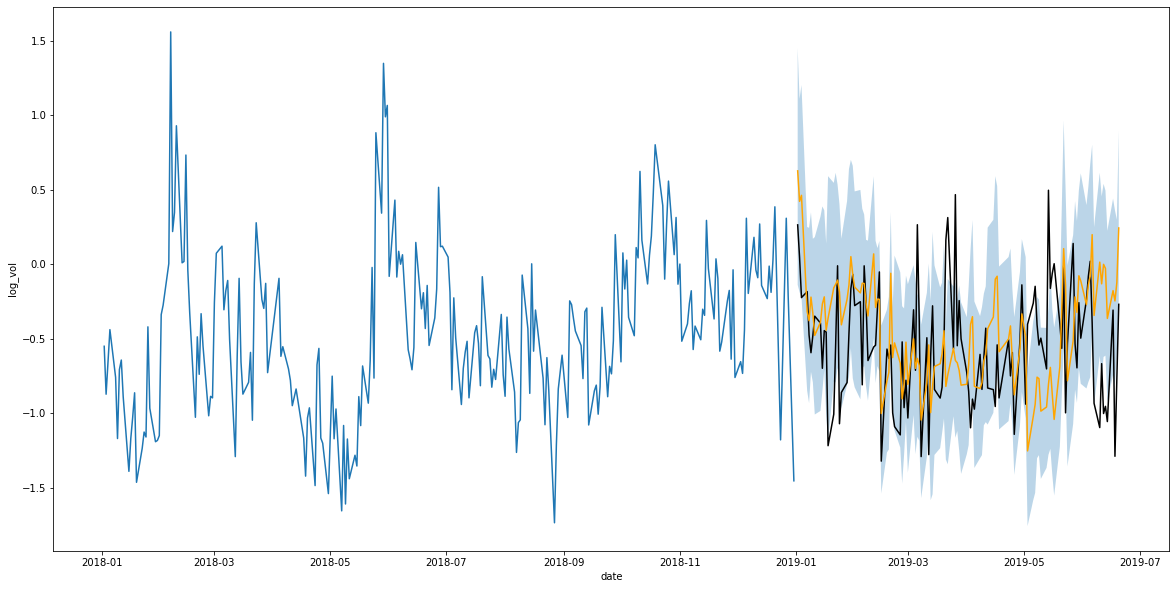

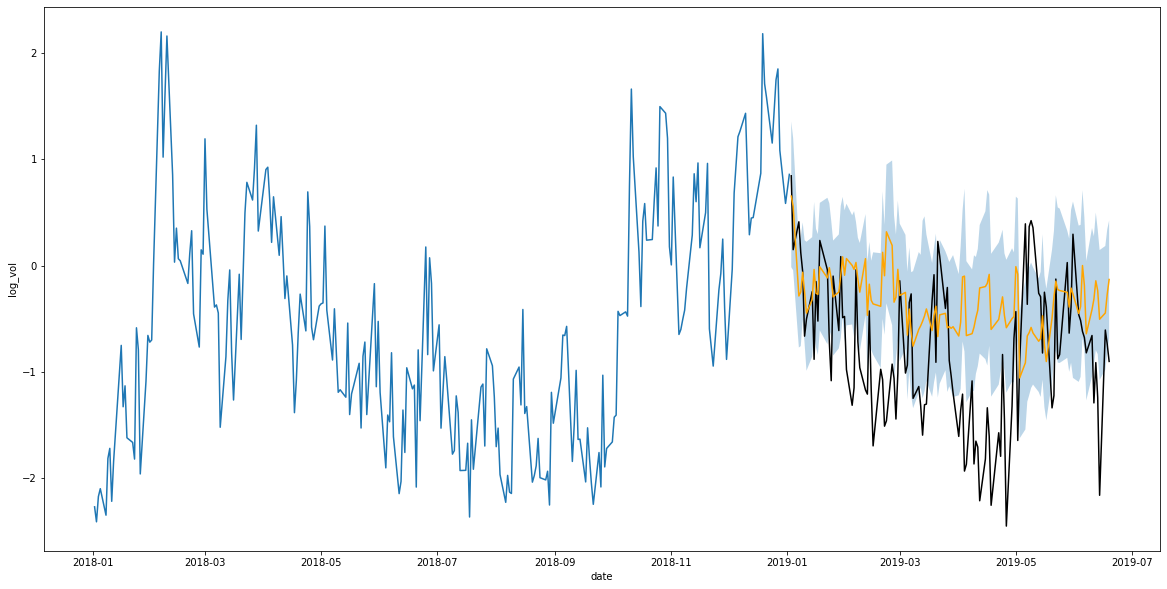

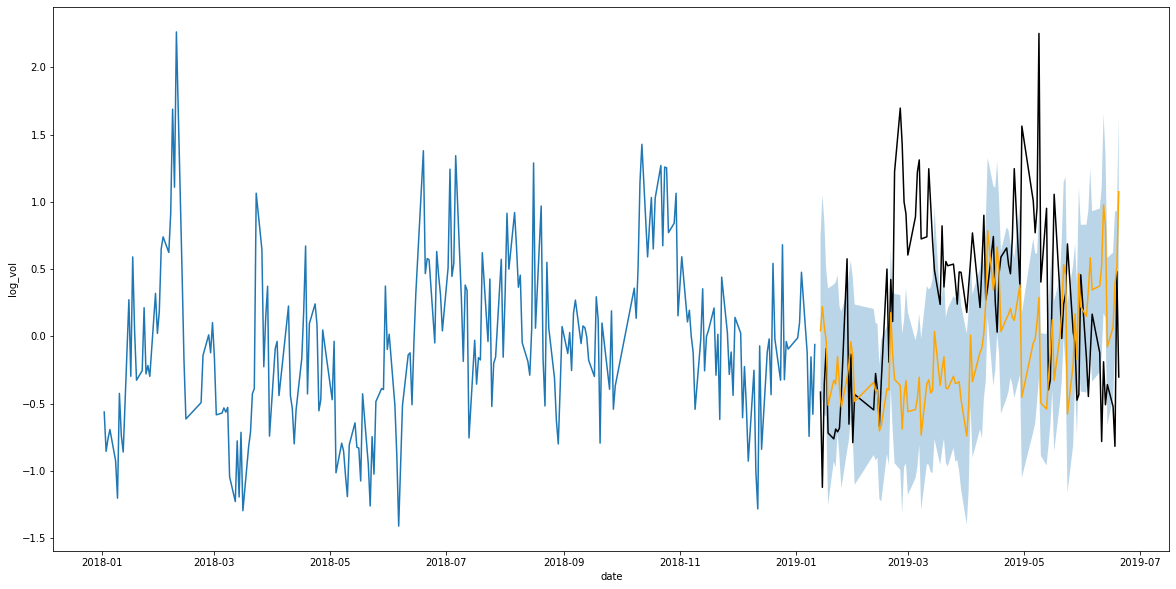

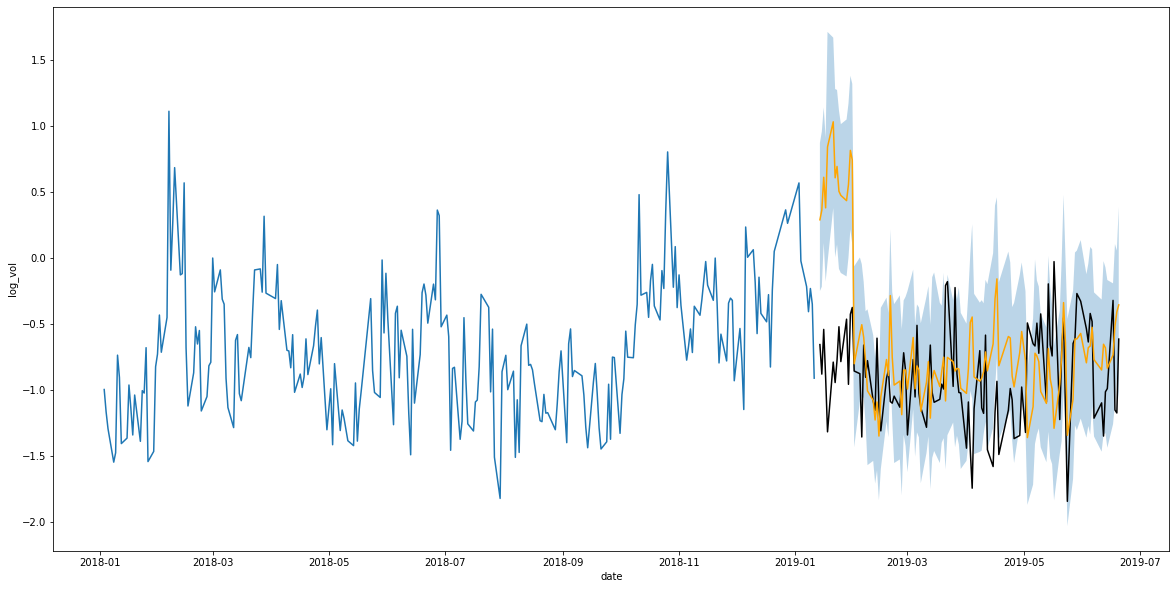

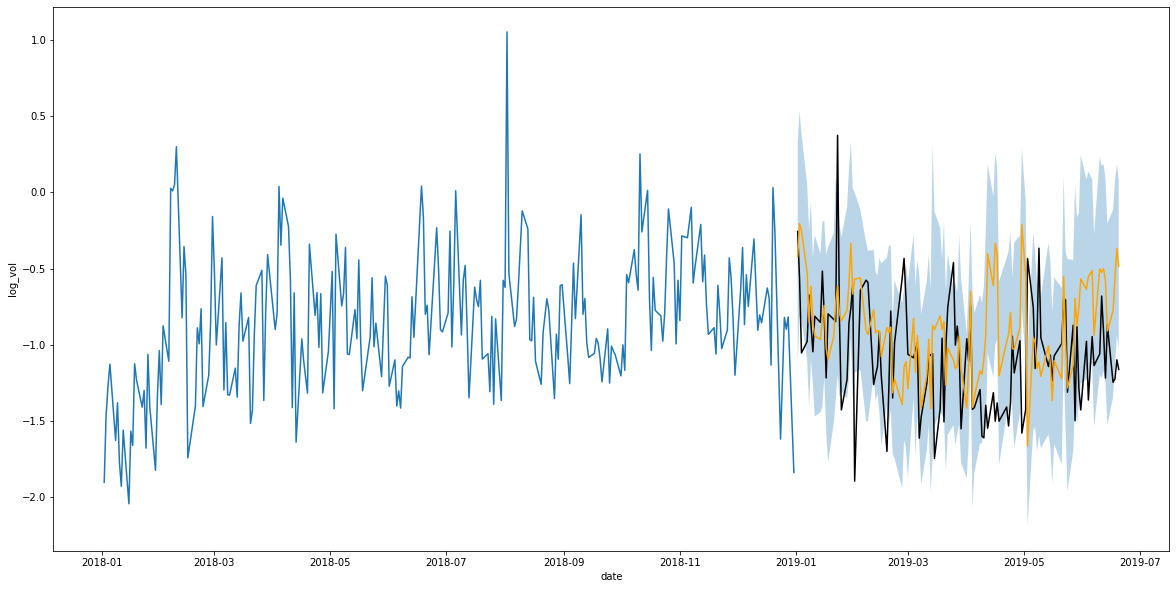

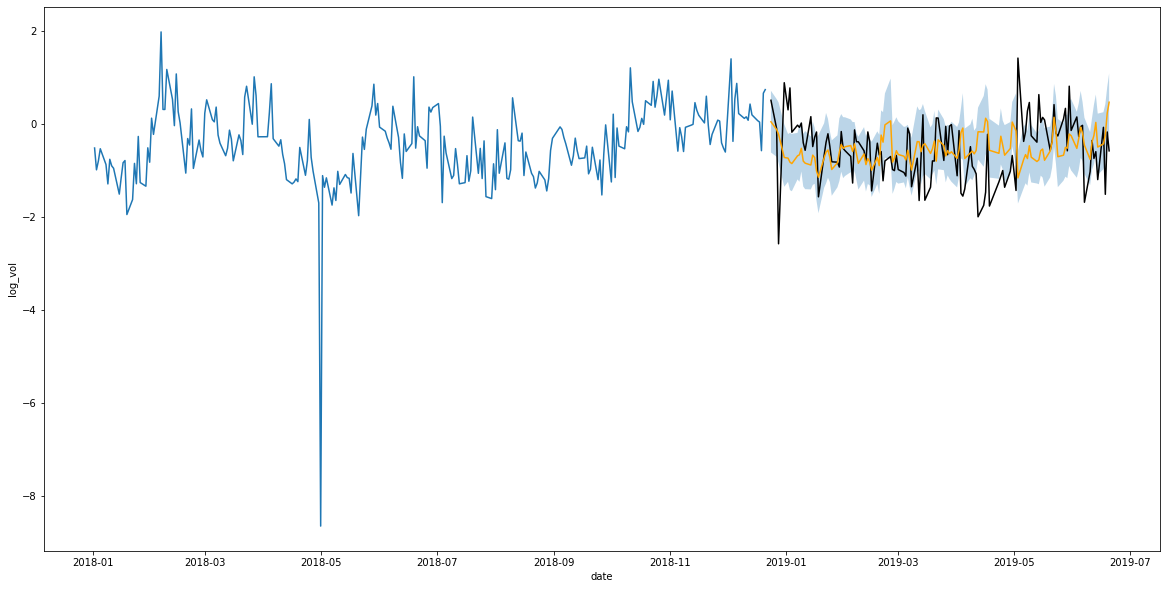

In [56]:
for i in test.Symbol.unique():
    plt.figure(figsize=(20,10))
    sns.lineplot(x=test[test["Symbol"]==i].iloc[:ENCODER_STEPS-1]["date"], y=test[test["Symbol"]==i].iloc[:ENCODER_STEPS-1]["log_vol"])
    sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].labels, color="black")
    #sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p10, color="red")
    sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p50, color="orange")
    #sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p90, color="green")

    plt.fill_between(out_df[out_df["identifier"]==i].index, out_df[out_df["identifier"]==i].p10, out_df[out_df["identifier"]==i].p90, alpha=0.3)

    plt.show()

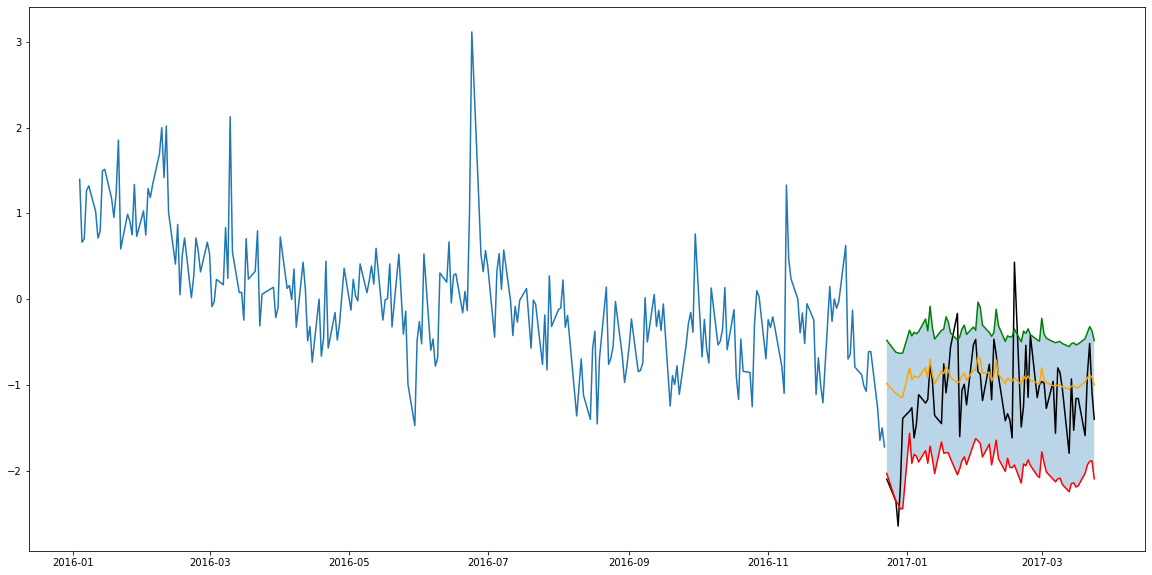

In [ ]:
dataiter = iter(valid_dataloader)
batch = dataiter.next()

dates = pd.to_datetime(batch['time'].numpy()[0,:252,0]).tolist()
for i in range(0, 64, 5):
    dates += pd.to_datetime(batch['time'].numpy()[i,252:,0]).tolist()

known = batch["inputs"].numpy()[0, :252, col_to_idx["log_vol"]]

labels = []
for i in range(0, 64, 5):
    labels += list(batch["outputs"].numpy()[i, :, 0])

outputs = model.forward(batch).to("cpu").detach().numpy()
outs = outputs.reshape(64,5,3)[:64:5,:,:].reshape(-1, 3)


plt.figure(figsize=(20,10))
sns.lineplot(x=dates[:252], y=known)
sns.lineplot(x=dates[252:], y=labels, color="black")
sns.lineplot(x=dates[252:], y=outs[:, 0], color="red")
sns.lineplot(x=dates[252:], y=outs[:, 1], color="orange")
sns.lineplot(x=dates[252:], y=outs[:, 2], color="green")

plt.fill_between(dates[252:], outs[:, 0], outs[:, 2], alpha=0.3)

plt.show()

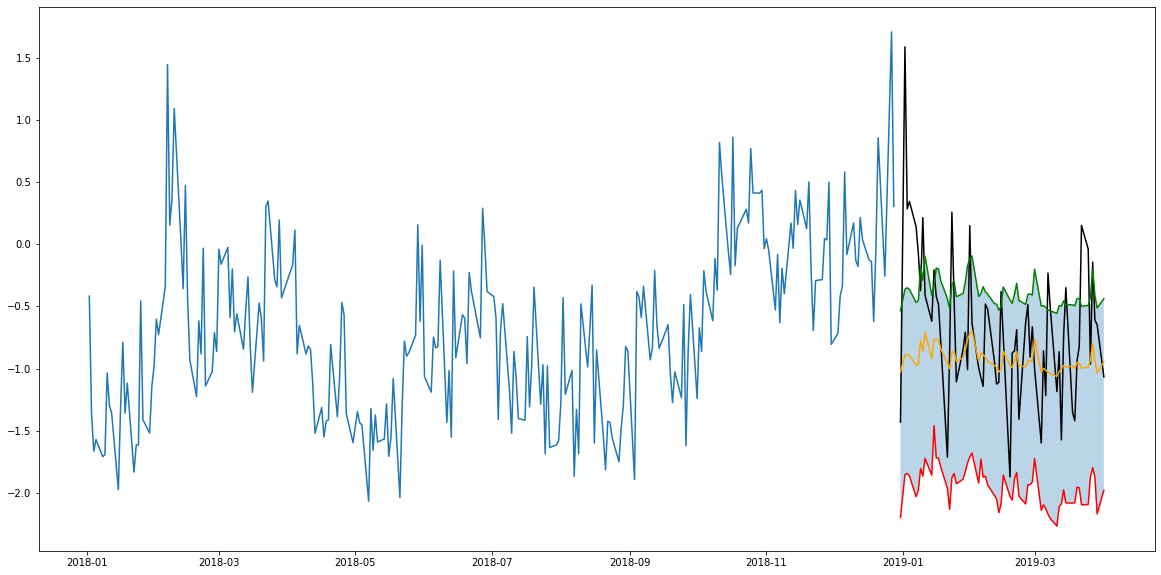

In [ ]:
dataiter = iter(test_dataloader)
batch = dataiter.next()

dates = pd.to_datetime(batch['time'].numpy()[0,:252,0]).tolist()
for i in range(0, 64, 5):
    dates += pd.to_datetime(batch['time'].numpy()[i,252:,0]).tolist()

known = batch["inputs"].numpy()[0, :252, col_to_idx["log_vol"]]

labels = []
for i in range(0, 64, 5):
    labels += list(batch["outputs"].numpy()[i, :, 0])

outputs = model.forward(batch).to("cpu").detach().numpy()
outs = outputs.reshape(64,5,3)[:64:5,:,:].reshape(-1, 3)


plt.figure(figsize=(20,10))
sns.lineplot(x=dates[:252], y=known)
sns.lineplot(x=dates[252:], y=labels, color="black")
sns.lineplot(x=dates[252:], y=outs[:, 0], color="red")
sns.lineplot(x=dates[252:], y=outs[:, 1], color="orange")
sns.lineplot(x=dates[252:], y=outs[:, 2], color="green")

plt.fill_between(dates[252:], outs[:, 0], outs[:, 2], alpha=0.3)

plt.show()